In [24]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.5"

import utils
from jax import numpy as jnp, random, tree_util
from chemtrain import quantity
from matplotlib import pyplot as plt
import pickle as pkl
import dataset

import numpy as np
from jax_md import partition, space

In [2]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/franz/CG-Mapping-Benchmark/utils.py'>

In [3]:
tick_font_size = 16
axis_label_font_size = 16
legend_font_size = 16

# ALA2

# preprocessing

In [4]:
import importlib
importlib.reload(dataset)
Ala2_Dataset = dataset.Ala2_Dataset()
Ala2_Dataset.coarse_grain('hmerged')

Ref_coords_AT = jnp.concatenate([
    jnp.array(Ala2_Dataset.dataset_U['training']['R']),
    jnp.array(Ala2_Dataset.dataset_U['validation']['R']),
    jnp.array(Ala2_Dataset.dataset_U['testing']['R'])
], axis=0)

Ref_coords_hmerged = jnp.concatenate([
    jnp.array(Ala2_Dataset.cg_dataset_U['training']['R']),
    jnp.array(Ala2_Dataset.cg_dataset_U['validation']['R']),
    jnp.array(Ala2_Dataset.cg_dataset_U['testing']['R'])
], axis=0)

Ref_forces_hmerged = jnp.concatenate([
    jnp.array(Ala2_Dataset.cg_dataset_U['training']['F']),
    jnp.array(Ala2_Dataset.cg_dataset_U['validation']['F']),
    jnp.array(Ala2_Dataset.cg_dataset_U['testing']['F'])
], axis=0)

Ala2_Dataset.coarse_grain('heavyOnly')
Ref_coords_heavyOnly = jnp.concatenate([
    jnp.array(Ala2_Dataset.cg_dataset_U['training']['R']),
    jnp.array(Ala2_Dataset.cg_dataset_U['validation']['R']),
    jnp.array(Ala2_Dataset.cg_dataset_U['testing']['R'])
], axis=0)

Ref_forces_heavyOnly = jnp.concatenate([
    jnp.array(Ala2_Dataset.cg_dataset_U['training']['F']),
    jnp.array(Ala2_Dataset.cg_dataset_U['validation']['F']),
    jnp.array(Ala2_Dataset.cg_dataset_U['testing']['F'])
], axis=0)

Ala2_Dataset.coarse_grain('coreBetaMap2')
Ref_coords_coreBetaMap2 = jnp.concatenate([
    jnp.array(Ala2_Dataset.cg_dataset_U['training']['R']),
    jnp.array(Ala2_Dataset.cg_dataset_U['validation']['R']),
    jnp.array(Ala2_Dataset.cg_dataset_U['testing']['R'])
], axis=0)

ala2_dihedral_fn_coreBetaMap2_improper = utils.init_dihedral_fn(Ala2_Dataset.displacement_fn_U, [[1,2,3,4]])
Ref_phi_coreBetaMap2_improper = ala2_dihedral_fn_coreBetaMap2_improper(Ref_coords_coreBetaMap2)

Loading Ala2 dataset from: /home/franz/l-ala2_ttot=500ns_dt=0.5fs_nstxout=2000.npz
Original positions: 0.0 to 3.2790000438690186
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.2790000438690186
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.2790000438690186
Scale dataset by 1 for R and 1 for U.
Training set size: 350000
Validation set size: 50000
Original positions: 0.0 to 3.279369592666626
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.279364585876465
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.279369592666626
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.2790000438690186
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.2790000438690186
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.2790000438690186
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.2790000438690186
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 

### distances

In [5]:
# Define the atom pairs
from numpy import mean

atom_pairs = [(4, 6), (6, 8), (8, 14), (14, 16)] # (C_ACE-N), (N-CA), (CA-C), (C-N_NME)
# Initialize lists to store results
heavyAtom_means = []
stds = []
cg_coords = np.concatenate([Ala2_Dataset.dataset_U['training']['R'],Ala2_Dataset.dataset_U['validation']['R'],Ala2_Dataset.dataset_U['testing']['R']], axis=0)
# Compute distances for each pair
for pair in atom_pairs:
    distances = utils.compute_atom_distance(cg_coords, pair[0], pair[1], Ala2_Dataset.displacement_fn_U)
    heavyAtom_mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    heavyAtom_means.append(heavyAtom_mean_distance)
    stds.append(std_distance)
    print(f"HeavyAtom Ref pair {pair}: Mean = {heavyAtom_mean_distance:.3f}, Std = {std_distance:.3f}")

hmerged_means = []
Ref_pairs_hmerged = [(1,3),(3,4),(4,6),(6,8)]
for pair in Ref_pairs_hmerged:
    distances = utils.compute_atom_distance(Ref_coords_hmerged, pair[0], pair[1], Ala2_Dataset.displacement_fn_U)
    hmerged_mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    hmerged_means.append(hmerged_mean_distance)
    print(f"UnitedAtom Ref pair {pair}: Mean = {hmerged_mean_distance:.3f}, Std = {std_distance:.3f}")

import jax

ala2_heavy_distance_filter = utils.setup_distance_filter_fn(heavyAtom_means, Ala2_Dataset.displacement_fn_U, delta=0.05)
ala2_hmerged_distance_filter = utils.setup_distance_filter_fn(hmerged_means, Ala2_Dataset.displacement_fn_U, delta=0.05)

HeavyAtom Ref pair (4, 6): Mean = 0.133, Std = 0.002
HeavyAtom Ref pair (6, 8): Mean = 0.147, Std = 0.003
HeavyAtom Ref pair (8, 14): Mean = 0.155, Std = 0.003
HeavyAtom Ref pair (14, 16): Mean = 0.134, Std = 0.002
UnitedAtom Ref pair (1, 3): Mean = 0.136, Std = 0.003
UnitedAtom Ref pair (3, 4): Mean = 0.153, Std = 0.003
UnitedAtom Ref pair (4, 6): Mean = 0.157, Std = 0.003
UnitedAtom Ref pair (6, 8): Mean = 0.137, Std = 0.003


In [6]:
ala2_dihedral_fn_heavyOnly = utils.init_dihedral_fn(Ala2_Dataset.displacement_fn_U, [[1, 3, 4, 6], [3, 4, 6, 8]])
Ref_phi_heavyOnly, Ref_psi_heavyOnly = ala2_dihedral_fn_heavyOnly(Ref_coords_heavyOnly)

ala2_dihedral_fn_hmerged = utils.init_dihedral_fn(Ala2_Dataset.displacement_fn_U, [[1, 3, 4, 6], [3, 4, 6, 8]])
Ref_phi_hmerged, Ref_psi_hmerged = ala2_dihedral_fn_hmerged(Ref_coords_hmerged)
ala2_dihedral_fn_coreBetaMap2 = utils.init_dihedral_fn(Ala2_Dataset.displacement_fn_U, [[0,1,2,4], [1,2,4,5]])

In [10]:
cg_results = {}
line_locs = utils.get_line_locations(0, 5000, 100, print_every=0.5)

Ref_coords= {
    'hmerged': Ref_coords_hmerged,
    'heavyOnly': Ref_coords_heavyOnly,
}
ala2_maps = {
    'AT': ([4, 6, 8, 14], [6, 8, 14, 16], [(4, 6), (6, 8), (8, 14), (14,16)], 'heavyOnly'),
    'hmerged': ([1, 3, 4, 6], [3, 4, 6, 8], [(1,3),(3,4),(4,6), (6,8)], 'hmerged'),
    'heavyOnly': ([1, 3, 4, 6], [3, 4, 6, 8], [(1,3),(3,4),(4,6), (6,8)], 'heavyOnly'),
    'core': ([0,1,2,3], [1,2,3,4], [(0,1),(1,2),(2,3), (3,4)], 'heavyOnly'),
    'coreMap2': ([0,1,2,3], [1,2,3,4], [(0,1),(1,2),(2,3), (3,4)], 'heavyOnly'),
    'coreBeta': ([0,1,2,4], [1,2,4,5], [(0,1),(1,2),(2,4), (4,5)], 'heavyOnly'),
    'coreBetaMap2': ([0,1,2,4], [1,2,4,5], [(0,1),(1,2),(2,4), (4,5)], 'heavyOnly'),
    'coreSingle': ([0,1,2,3], [1,2,3,4], [(0,1),(1,2),(2,3), (3,4)], 'heavyOnly'),
    'coreBetaSingle': ([0,1,2,4], [1,2,4,5], [(0,1),(1,2),(2,4), (4,5)], 'heavyOnly'),
}

epochs = 50

for cgmap, base_path in {
    "AT": 'Amino_acids/capped_ala/Ala2_map=AT/',
    "hmerged": 'Amino_acids/capped_ala/Ala2_map=hmerged/',
    "heavyOnly": 'Amino_acids/capped_ala/Ala2_map=heavyOnly/',
    "core": 'Amino_acids/capped_ala/Ala2_map=core/',
    "coreMap2": 'Amino_acids/capped_ala/Ala2_map=coreMap2/',
    "coreSingle": 'Amino_acids/capped_ala/Ala2_map=coreSingle/',
    "coreBeta": 'Amino_acids/capped_ala/Ala2_map=coreBeta/',
    "coreBetaMap2": 'Amino_acids/capped_ala/Ala2_map=coreBetaMap2/',
    "coreBetaSingle": 'Amino_acids/capped_ala/Ala2_map=coreBetaSingle/',
}.items():
    cg_names = []
    cg_coords = []
    cg_kTs = []
    cg_epots = []
    cg_etots = []
    cg_forces = []
    dt_values_fs = [2] # [0.5, 2, 4, 8]
    dt_values_fs_AT = [0.5] # [0.5, 2, 4, 8]
    temperatures = [300]
    
    print(f'\n Processing CG map: {cgmap}')
    t_eq = 0
    t_tot = 5000
    n_chains = 100
    seed = 22
    phi_idcs, psi_idcs, core_bond_idcs, ref_name = ala2_maps[cgmap]
    
    for T in temperatures:
        for dt in dt_values_fs_AT if cgmap == "AT" else dt_values_fs:
            cg_path = f'{base_path}simulation_NVT_T={T}.0K/traj_mol=ala2_dt={dt}_teq={t_eq}_t={t_tot}_nmol=1_nchains={n_chains}_mode=sampling_seed={seed}'
            name = f'traj_mol=ala2_dt={dt}_teq={t_eq}_t={t_tot}_nmol=1_nchains={n_chains}_mode=sampling_seed={seed}'
            
            aux_path = os.path.join(cg_path, 'traj_state_aux.pkl')
            traj_path = os.path.join(cg_path, 'trajectory.pkl')

            traj_aux = pkl.load(open(aux_path, 'rb'))
            traj = pkl.load(open(traj_path, 'rb'))

            traj_coords = np.array(traj)
            traj_force = traj_aux['force']
            traj_kT = traj_aux['kT']
            traj_epot = traj_aux['epot']
            traj_etot = traj_aux['etot']

            # Apply distance filtering
            filter_fn = ala2_hmerged_distance_filter if cgmap == 'hmerged' else ala2_heavy_distance_filter
            traj_coords = utils.split_into_chains(traj_coords, line_locs)
            print('traj shape before filtering:', traj_coords.shape)
            traj_coords, combined_mask = filter_fn(
                traj_coords,
                indices=core_bond_idcs
            )
            # reshape mask and traj back to (n_chains*n_frames, ...)
            n_chains, n_frames, n_atoms, _ = traj_coords.shape
            traj_coords = traj_coords.reshape((n_chains * n_frames, n_atoms, 3))
            combined_mask = combined_mask.reshape((n_chains * n_frames,))
            
            dihedral_fn = utils.init_dihedral_fn(Ala2_Dataset.displacement_fn_U, [phi_idcs, psi_idcs])
            phi, psi = dihedral_fn(jnp.array(traj_coords))
            phi = np.array(phi)
            psi = np.array(psi)
            mask = np.isfinite(phi) & np.isfinite(psi)
            phi = phi[mask]
            psi = psi[mask]
            
            traj_force = traj_force[combined_mask]
            traj_kT = traj_kT[combined_mask]
            traj_epot = traj_epot[combined_mask]
            traj_etot = traj_etot[combined_mask]
            
            cg_names.append(name)
            cg_kTs.append(traj_kT)
            cg_epots.append(traj_epot)
            cg_coords.append(traj_coords)
            cg_etots.append(traj_etot)
            cg_forces.append(traj_force)
            
            cg_results[cgmap] = {
                "names": cg_names,
                "coords": cg_coords,
                "forces": cg_forces,
                "kTs": cg_kTs,
                "epots": cg_epots,
                "etots": cg_etots,
                "dt_values_fs": dt_values_fs,
                "t_eq": t_eq,
                "t_tot": t_tot,
                "base_path": base_path,
                "phi_idcs": phi_idcs,
                "psi_idcs": psi_idcs,
                "core_bond_idcs": core_bond_idcs,
                "ref_name": ref_name,
                "line_locations": utils.get_line_locations(t_eq, t_tot, n_chains, print_every=0.5),
                'N_distance_removed_frames': int(jnp.sum(~combined_mask)),
                "phi": phi,
                "psi": psi,
            }



 Processing CG map: AT
traj shape before filtering: (100, 10000, 22, 3)
Input shape: (100, 10000, 22, 3)
>> Processed shape: (100, 10000, 22, 3)
>> Valid frames per chain ns 5000.0 ± 0.0
>> Chains with at least one invalid frame: 0/100

 Processing CG map: hmerged
traj shape before filtering: (100, 10000, 10, 3)
Input shape: (100, 10000, 10, 3)
>> Processed shape: (100, 10000, 10, 3)
>> Valid frames per chain ns 5000.0 ± 0.0
>> Chains with at least one invalid frame: 0/100

 Processing CG map: heavyOnly
traj shape before filtering: (100, 10000, 10, 3)
Input shape: (100, 10000, 10, 3)
>> Processed shape: (100, 10000, 10, 3)
>> Valid frames per chain ns 5000.0 ± 0.0
>> Chains with at least one invalid frame: 0/100

 Processing CG map: core
traj shape before filtering: (100, 10000, 5, 3)
Input shape: (100, 10000, 5, 3)
>> Processed shape: (100, 10000, 5, 3)
>> Valid frames per chain ns 5000.0 ± 0.0
>> Chains with at least one invalid frame: 0/100

 Processing CG map: coreMap2
traj shape 

# Dihedrals

## Heavy vs hmerged

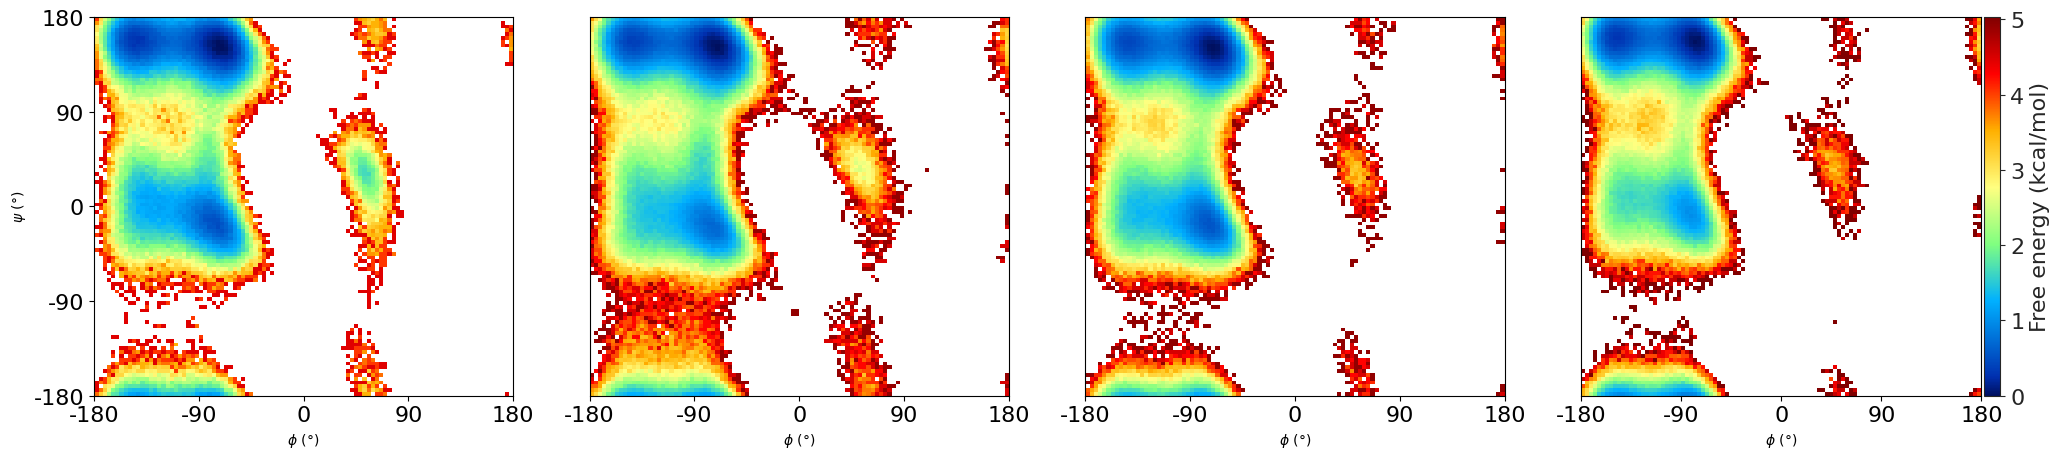

In [11]:
import importlib 
importlib.reload(utils)

fig, axes = plt.subplots(1, 4, figsize=(21, 5))
axes = axes.flatten()
bins = 100

phis = [cg_results['AT']['phi'], cg_results['heavyOnly']['phi'], cg_results['hmerged']['phi'], Ref_phi_heavyOnly]
psis = [cg_results['AT']['psi'], cg_results['heavyOnly']['psi'], cg_results['hmerged']['psi'], Ref_psi_heavyOnly]
scale_used = utils.determine_free_energy_scale(phis, psis, 300. * quantity.kb, bins=bins)

utils.plot_histogram_free_energy(axes[0], Ref_phi_heavyOnly, Ref_psi_heavyOnly, 300. * quantity.kb, show_ylabel=True, show_yticks=True, scale=scale_used)
utils.plot_histogram_free_energy(axes[1], cg_results['AT']['phi'], cg_results['AT']['psi'], 300. * quantity.kb, show_ylabel=False, show_yticks=False, scale=scale_used)
utils.plot_histogram_free_energy(axes[2], cg_results['heavyOnly']['phi'], cg_results['heavyOnly']['psi'], 300. * quantity.kb, show_ylabel=False, show_yticks=False, scale=scale_used)
utils.plot_histogram_free_energy(axes[3], cg_results['hmerged']['phi'], cg_results['hmerged']['psi'], 300. * quantity.kb, show_ylabel=False, show_yticks=False, legend=True, scale=scale_used)

for ax in axes:
	ax.tick_params(axis='both', labelsize=tick_font_size)

plt.tight_layout()
# plt.savefig('ala2_heavy_grid_dt=2fs.pdf')


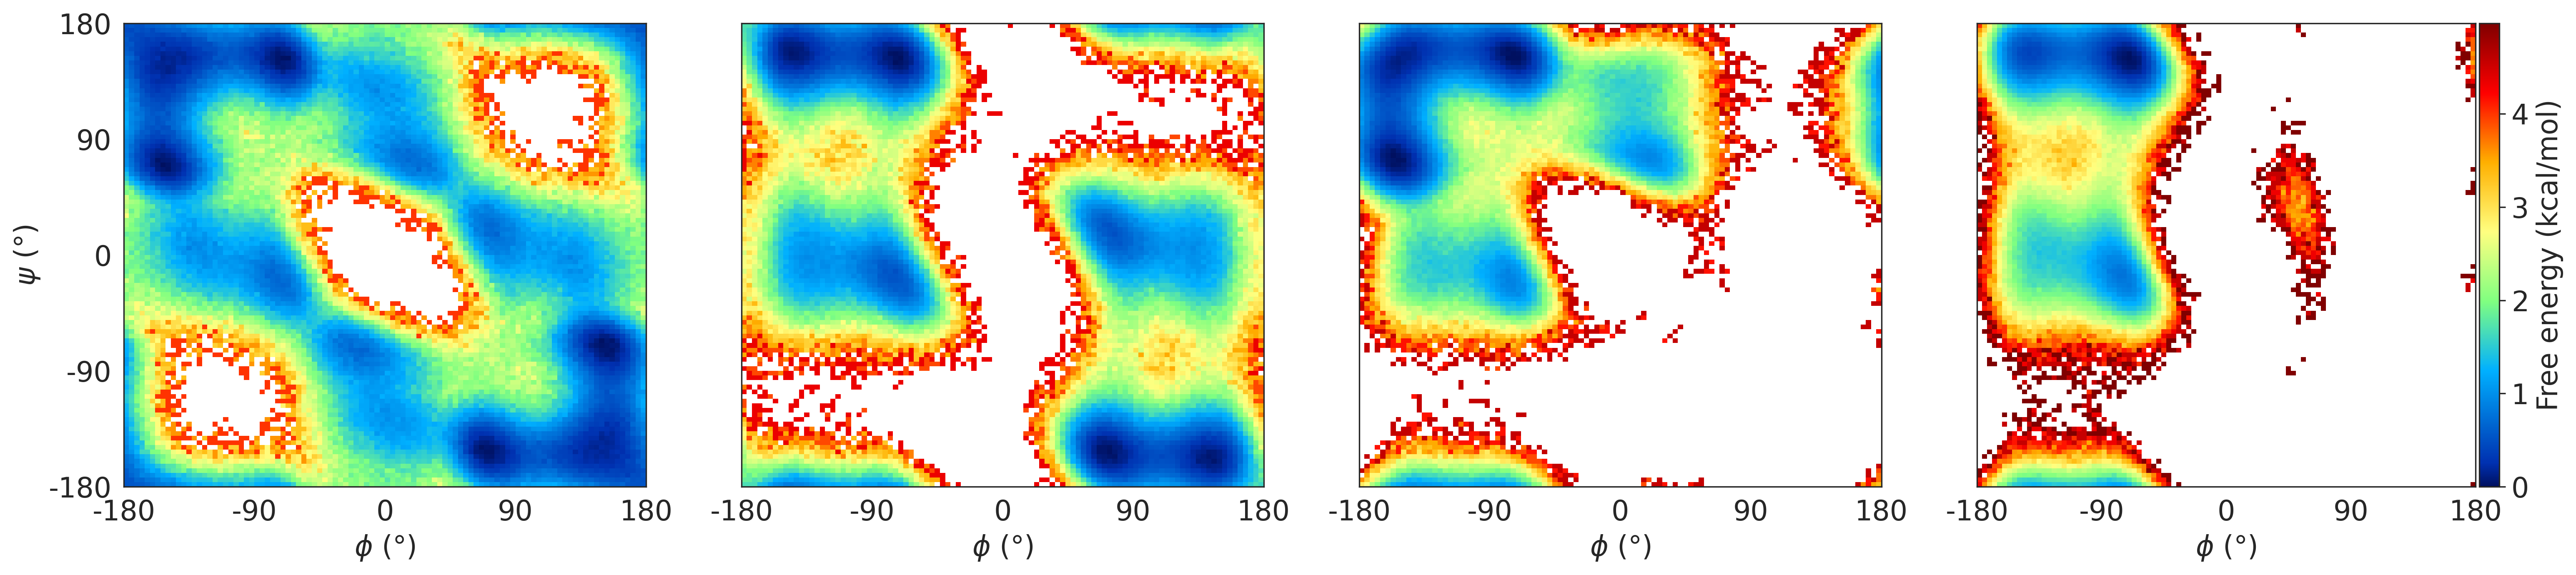

In [13]:
import importlib 
importlib.reload(utils)

fig, axes = plt.subplots(1, 4, figsize=(21, 5))
axes = axes.flatten()

bins = 100
scale_used = utils.determine_free_energy_scale([cg_results['coreSingle']['phi'],cg_results['core']['phi'],cg_results['coreBetaSingle']['phi'],cg_results['coreBeta']['phi']], [cg_results['coreSingle']['psi'],cg_results['core']['psi'],cg_results['coreBetaSingle']['psi'],cg_results['coreBeta']['psi']], 300. * quantity.kb, bins=bins)

utils.plot_histogram_free_energy(axes[0], cg_results['coreSingle']['phi'], cg_results['coreSingle']['psi'], 300. * quantity.kb, show_ylabel=True, scale=scale_used, bins=bins)
utils.plot_histogram_free_energy(axes[1], cg_results['core']['phi'], cg_results['core']['psi'], 300. * quantity.kb, scale=scale_used, bins=bins, show_yticks=False)
utils.plot_histogram_free_energy(axes[2], cg_results['coreBetaSingle']['phi'], cg_results['coreBetaSingle']['psi'], 300. * quantity.kb, scale=scale_used, bins=bins, show_yticks=False)
utils.plot_histogram_free_energy(axes[3], cg_results['coreBeta']['phi'], cg_results['coreBeta']['psi'], 300. * quantity.kb, legend=True, show_yticks=False, scale=scale_used, bins=bins)

for ax in axes:
	ax.tick_params(axis='both', labelsize=tick_font_size)

plt.tight_layout()
# plt.savefig('backbone_ramachandran_comparison_row.pdf')

# NequIP

In [9]:
cg_results_nequip = {}
line_locs = utils.get_line_locations(0, 5000, 100, print_every=0.5)

Ref_coords= {
    'hmerged': Ref_coords_hmerged,
    'heavyOnly': Ref_coords_heavyOnly,
}
ala2_maps = {
    'core': ([0,1,2,3], [1,2,3,4], [(0,1),(1,2),(2,3), (3,4)], 'heavyOnly'),
    'coreSingle': ([0,1,2,3], [1,2,3,4], [(0,1),(1,2),(2,3), (3,4)], 'heavyOnly'),
    'coreBeta': ([0,1,2,4], [1,2,4,5], [(0,1),(1,2),(2,4), (4,5)], 'heavyOnly'),
    'coreBetaSingle': ([0,1,2,4], [1,2,4,5], [(0,1),(1,2),(2,4), (4,5)], 'heavyOnly'),
}

epochs = 50

for cgmap, base_path in {
    "core": 'MLP_train_nequip/Ala2_map=core_tr=0.9_epochs=50/simulation_NVT_T=300.0K/',
    "coreSingle": 'MLP_train_nequip/Ala2_map=coreSingle_tr=0.9_epochs=50/simulation_NVT_T=300.0K/',
    "coreBeta": 'MLP_train_nequip/Ala2_map=coreBeta_tr=0.9_epochs=50/simulation_NVT_T=300.0K/',
    "coreBetaSingle": 'MLP_train_nequip/Ala2_map=coreBetaSingle_tr=0.9_epochs=50/simulation_NVT_T=300.0K/',
}.items():
    cg_names = []
    cg_coords = []
    cg_kTs = []
    cg_epots = []
    cg_etots = []
    cg_forces = []
    dt_values_fs = [2] 
    
    print(f'\n Processing CG map: {cgmap}')
    phi_idcs, psi_idcs, core_bond_idcs, ref_name = ala2_maps[cgmap]

    for dt in dt_values_fs:
        cg_path = f'{base_path}/traj_mol=ala2_dt=2_teq=0_t=5000_nmol=1_nchains=100_mode=sampling_seed=22'
        name = f'traj_mol=ala2_dt={dt}_teq={t_eq}_t={t_tot}_nmol=1_nchains={n_chains}_mode=sampling_seed={seed}'
        
        aux_path = os.path.join(cg_path, 'traj_state_aux.pkl')
        traj_path = os.path.join(cg_path, 'trajectory.pkl')

        traj_aux = pkl.load(open(aux_path, 'rb'))
        traj = pkl.load(open(traj_path, 'rb'))

        traj_coords = np.array(traj)
        traj_force = traj_aux['force']
        traj_kT = traj_aux['kT']
        traj_epot = traj_aux['epot']
        traj_etot = traj_aux['etot']

        # Apply distance filtering
        filter_fn = ala2_hmerged_distance_filter if cgmap == 'hmerged' else ala2_heavy_distance_filter
        traj_coords = utils.split_into_chains(traj_coords, line_locs)
        print('traj shape before filtering:', traj_coords.shape)
        traj_coords, combined_mask = filter_fn(
            traj_coords,
            indices=core_bond_idcs
        )
        # reshape mask and traj back to (n_chains*n_frames, ...)
        n_chains, n_frames, n_atoms, _ = traj_coords.shape
        traj_coords = traj_coords.reshape((n_chains * n_frames, n_atoms, 3))
        combined_mask = combined_mask.reshape((n_chains * n_frames,))
        
        dihedral_fn = utils.init_dihedral_fn(Ala2_Dataset.displacement_fn_U, [phi_idcs, psi_idcs])
        phi, psi = dihedral_fn(jnp.array(traj_coords))
        phi = np.array(phi)
        psi = np.array(psi)
        mask = np.isfinite(phi) & np.isfinite(psi)
        phi = phi[mask]
        psi = psi[mask]
        
        traj_force = traj_force[combined_mask]
        traj_kT = traj_kT[combined_mask]
        traj_epot = traj_epot[combined_mask]
        traj_etot = traj_etot[combined_mask]
        
        cg_names.append(name)
        cg_kTs.append(traj_kT)
        cg_epots.append(traj_epot)
        cg_coords.append(traj_coords)
        cg_etots.append(traj_etot)
        cg_forces.append(traj_force)
        
        cg_results_nequip[cgmap] = {
            "names": cg_names,
            "coords": cg_coords,
            "forces": cg_forces,
            "kTs": cg_kTs,
            "epots": cg_epots,
            "etots": cg_etots,
            "dt_values_fs": dt_values_fs,
            "t_eq": t_eq,
            "t_tot": t_tot,
            "base_path": base_path,
            "phi_idcs": phi_idcs,
            "psi_idcs": psi_idcs,
            "core_bond_idcs": core_bond_idcs,
            "ref_name": ref_name,
            "line_locations": utils.get_line_locations(t_eq, t_tot, n_chains, print_every=0.5),
            'N_distance_removed_frames': int(jnp.sum(~combined_mask)),
            "phi": phi,
            "psi": psi,
        }



 Processing CG map: core
traj shape before filtering: (100, 10000, 5, 3)
Input shape: (100, 10000, 5, 3)
>> Processed shape: (100, 10000, 5, 3)
>> Valid frames per chain ns 5000.0 ± 0.0
>> Chains with at least one invalid frame: 0/100

 Processing CG map: coreSingle
traj shape before filtering: (100, 10000, 5, 3)
Input shape: (100, 10000, 5, 3)
>> Processed shape: (100, 10000, 5, 3)
>> Valid frames per chain ns 5000.0 ± 0.0
>> Chains with at least one invalid frame: 0/100

 Processing CG map: coreBeta
traj shape before filtering: (100, 10000, 6, 3)
Input shape: (100, 10000, 6, 3)
>> Processed shape: (100, 10000, 6, 3)
>> Valid frames per chain ns 5000.0 ± 0.0
>> Chains with at least one invalid frame: 0/100

 Processing CG map: coreBetaSingle
traj shape before filtering: (100, 10000, 6, 3)
Input shape: (100, 10000, 6, 3)
>> Processed shape: (100, 10000, 6, 3)
>> Valid frames per chain ns 5000.0 ± 0.0
>> Chains with at least one invalid frame: 0/100


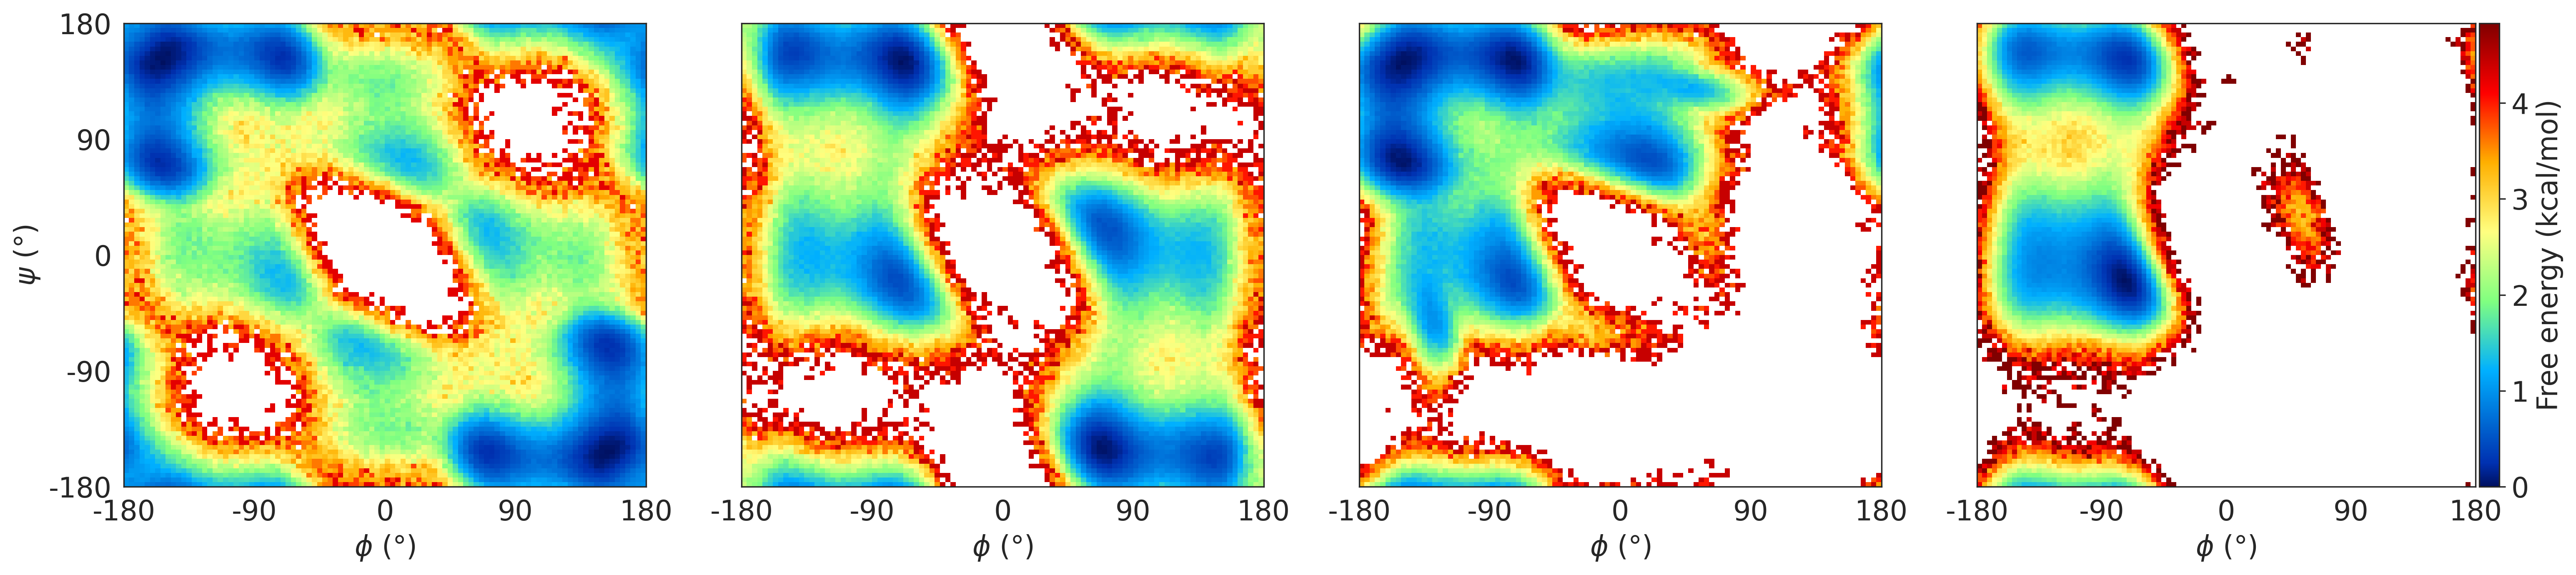

In [13]:
import importlib 
importlib.reload(utils)

fig, axes = plt.subplots(1, 4, figsize=(21, 5))
axes = axes.flatten()

bins = 100
scale_used = utils.determine_free_energy_scale([cg_results_nequip['coreSingle']['phi'],cg_results_nequip['core']['phi'],cg_results_nequip['coreBetaSingle']['phi'],cg_results_nequip['coreBeta']['phi']], [cg_results_nequip['coreSingle']['psi'],cg_results_nequip['core']['psi'],cg_results_nequip['coreBetaSingle']['psi'],cg_results_nequip['coreBeta']['psi']], 300. * quantity.kb, bins=bins)

utils.plot_histogram_free_energy(axes[0], cg_results_nequip['coreSingle']['phi'], cg_results_nequip['coreSingle']['psi'], 300. * quantity.kb, show_ylabel=True, scale=scale_used, bins=bins)
utils.plot_histogram_free_energy(axes[1], cg_results_nequip['core']['phi'], cg_results_nequip['core']['psi'], 300. * quantity.kb, scale=scale_used, bins=bins, show_yticks=False)
utils.plot_histogram_free_energy(axes[2], cg_results_nequip['coreBetaSingle']['phi'], cg_results_nequip['coreBetaSingle']['psi'], 300. * quantity.kb, scale=scale_used, bins=bins, show_yticks=False)
utils.plot_histogram_free_energy(axes[3], cg_results_nequip['coreBeta']['phi'], cg_results_nequip['coreBeta']['psi'], 300. * quantity.kb, legend=True, show_yticks=False, scale=scale_used, bins=bins)

for ax in axes:
	ax.tick_params(axis='both', labelsize=tick_font_size)

plt.tight_layout()
plt.savefig('NequIP_ala2_low_res_ramachandran_comparison.pdf')

# Ala2 Time step Analysis

In [21]:
dt_results_ala2 = {}

Ref_coords= {
    'hmerged': Ref_coords_hmerged,
    'heavyOnly': Ref_coords_heavyOnly,
}
ala2_maps = {
    'AT': ([4, 6, 8, 14], [6, 8, 14, 16], [(4, 6), (6, 8), (8, 14), (14,16)], 'heavyOnly'),
    'hmerged': ([1, 3, 4, 6], [3, 4, 6, 8], [(1,3),(3,4),(4,6), (6,8)], 'hmerged'),
    'heavyOnly': ([1, 3, 4, 6], [3, 4, 6, 8], [(1,3),(3,4),(4,6), (6,8)], 'heavyOnly'),
    'heavyOnlyMap2': ([1, 3, 4, 6], [3, 4, 6, 8], [(1,3),(3,4),(4,6), (6,8)], 'heavyOnly'),
    'core': ([0,1,2,3], [1,2,3,4], [(0,1),(1,2),(2,3), (3,4)], 'heavyOnly'),
    'coreMap2': ([0,1,2,3], [1,2,3,4], [(0,1),(1,2),(2,3), (3,4)], 'heavyOnly'),
    'coreBeta': ([0,1,2,4], [1,2,4,5], [(0,1),(1,2),(2,4), (4,5)], 'heavyOnly'),
    'coreBetaMap2': ([0,1,2,4], [1,2,4,5], [(0,1),(1,2),(2,4), (4,5)], 'heavyOnly'),
    'coreSingle': ([0,1,2,3], [1,2,3,4], [(0,1),(1,2),(2,3), (3,4)], 'heavyOnly'),
    'coreBetaSingle': ([0,1,2,4], [1,2,4,5], [(0,1),(1,2),(2,4), (4,5)], 'heavyOnly'),
}

epochs = 50

for cgmap, base_path in {
    "AT": 'Amino_acids/capped_ala/Ala2_map=AT/',
    "hmerged": 'Amino_acids/capped_ala/Ala2_map=hmerged/',
    "heavyOnly": 'Amino_acids/capped_ala/Ala2_map=heavyOnly/',
    "core": 'Amino_acids/capped_ala/Ala2_map=core/',
    "coreMap2": 'Amino_acids/capped_ala/Ala2_map=coreMap2/',
    "coreBeta": 'Amino_acids/capped_ala/Ala2_map=coreBeta/',
    "coreBetaMap2": 'Amino_acids/capped_ala/Ala2_map=coreBetaMap2/',
    "coreSingle": 'Amino_acids/capped_ala/Ala2_map=coreSingle/',
    "coreBetaSingle": 'Amino_acids/capped_ala/Ala2_map=coreBetaSingle/',
}.items():
    cg_names = []
    cg_coords = []
    cg_kTs = []
    cg_epots = []
    cg_etots = []
    cg_forces = []
    dt_values_fs = [0.5,1,2,3,4,5] # [0.5, 2, 4, 8]
    temperatures = [300]
    
    print(f'\n Processing CG map: {cgmap}')
    t_eq = 0
    t_tot = 100
    n_chains = 100
    seed = 22
    phi_idcs, psi_idcs, core_bond_idcs, ref_name = ala2_maps[cgmap]
    
    for T in temperatures:
        for dt in dt_values_fs:
            cg_path = f'{base_path}simulation_NVE_T={T}K/traj_mol=ala2_dt={dt}_teq={t_eq}_t={t_tot}_nmol=1_nchains={n_chains}_mode=sampling_seed={seed}'
            if not os.path.exists(cg_path):
                cg_path = f'{base_path}simulation_NVE_T={T}.0K/traj_mol=ala2_dt={dt}_teq={t_eq}_t={t_tot}_nmol=1_nchains={n_chains}_mode=sampling_seed={seed}'
                
                
            print(f'-'*50)
            print(f"dt: {dt} fs, T: {T} K")
            
            traj_path = os.path.join(cg_path, 'trajectory.pkl')
            aux_path = os.path.join(cg_path, 'traj_state_aux.pkl')

            traj_aux = pkl.load(open(aux_path, 'rb'))
            traj = pkl.load(open(traj_path, 'rb'))

            traj_coords = np.array(traj)
            traj_force = traj_aux['force']
            traj_kT = traj_aux['kT']
            traj_epot = traj_aux['epot']
            traj_etot = traj_aux['etot']

            # Apply distance filtering
            filter_fn = ala2_hmerged_distance_filter if cgmap == 'hmerged' else ala2_heavy_distance_filter
            traj_coords = utils.split_into_chains(traj_coords, line_locs)
            print('traj shape before filtering:', traj_coords.shape)
            traj_coords, combined_mask = filter_fn(
                traj_coords,
                indices=core_bond_idcs
            )
            # reshape mask and traj back to (n_chains*n_frames, ...)
            n_chains, n_frames, n_atoms, _ = traj_coords.shape
            traj_coords = traj_coords.reshape((n_chains * n_frames, n_atoms, 3))
            combined_mask = combined_mask.reshape((n_chains * n_frames,))
            
            traj_force = traj_force[combined_mask]
            traj_kT = traj_kT[combined_mask]
            traj_epot = traj_epot[combined_mask]
            traj_etot = traj_etot[combined_mask]
            
            cg_names.append(name)
            cg_kTs.append(traj_kT)
            cg_epots.append(traj_epot)
            cg_coords.append(traj_coords)
            cg_etots.append(traj_etot)
            cg_forces.append(traj_force)
          


 Processing CG map: AT
--------------------------------------------------
dt: 0.5 fs, T: 300 K
traj shape before filtering: (100, 10000, 22, 3)
Input shape: (100, 10000, 22, 3)
>> Processed shape: (100, 10000, 22, 3)
>> Valid frames per chain ns 5000.0 ± 0.0
>> Chains with at least one invalid frame: 0/100
--------------------------------------------------
dt: 1 fs, T: 300 K
traj shape before filtering: (100, 10000, 22, 3)
Input shape: (100, 10000, 22, 3)
>> Processed shape: (100, 10000, 22, 3)
>> Valid frames per chain ns 4936.5 ± 451.2
>> Chains with at least one invalid frame: 3/100
--------------------------------------------------
dt: 2 fs, T: 300 K
traj shape before filtering: (100, 10000, 22, 3)
Input shape: (100, 10000, 22, 3)
>> Processed shape: (100, 10000, 22, 3)
>> Valid frames per chain ns 3768.1 ± 1450.2
>> Chains with at least one invalid frame: 61/100
--------------------------------------------------
dt: 3 fs, T: 300 K
traj shape before filtering: (100, 10000, 22, 3)


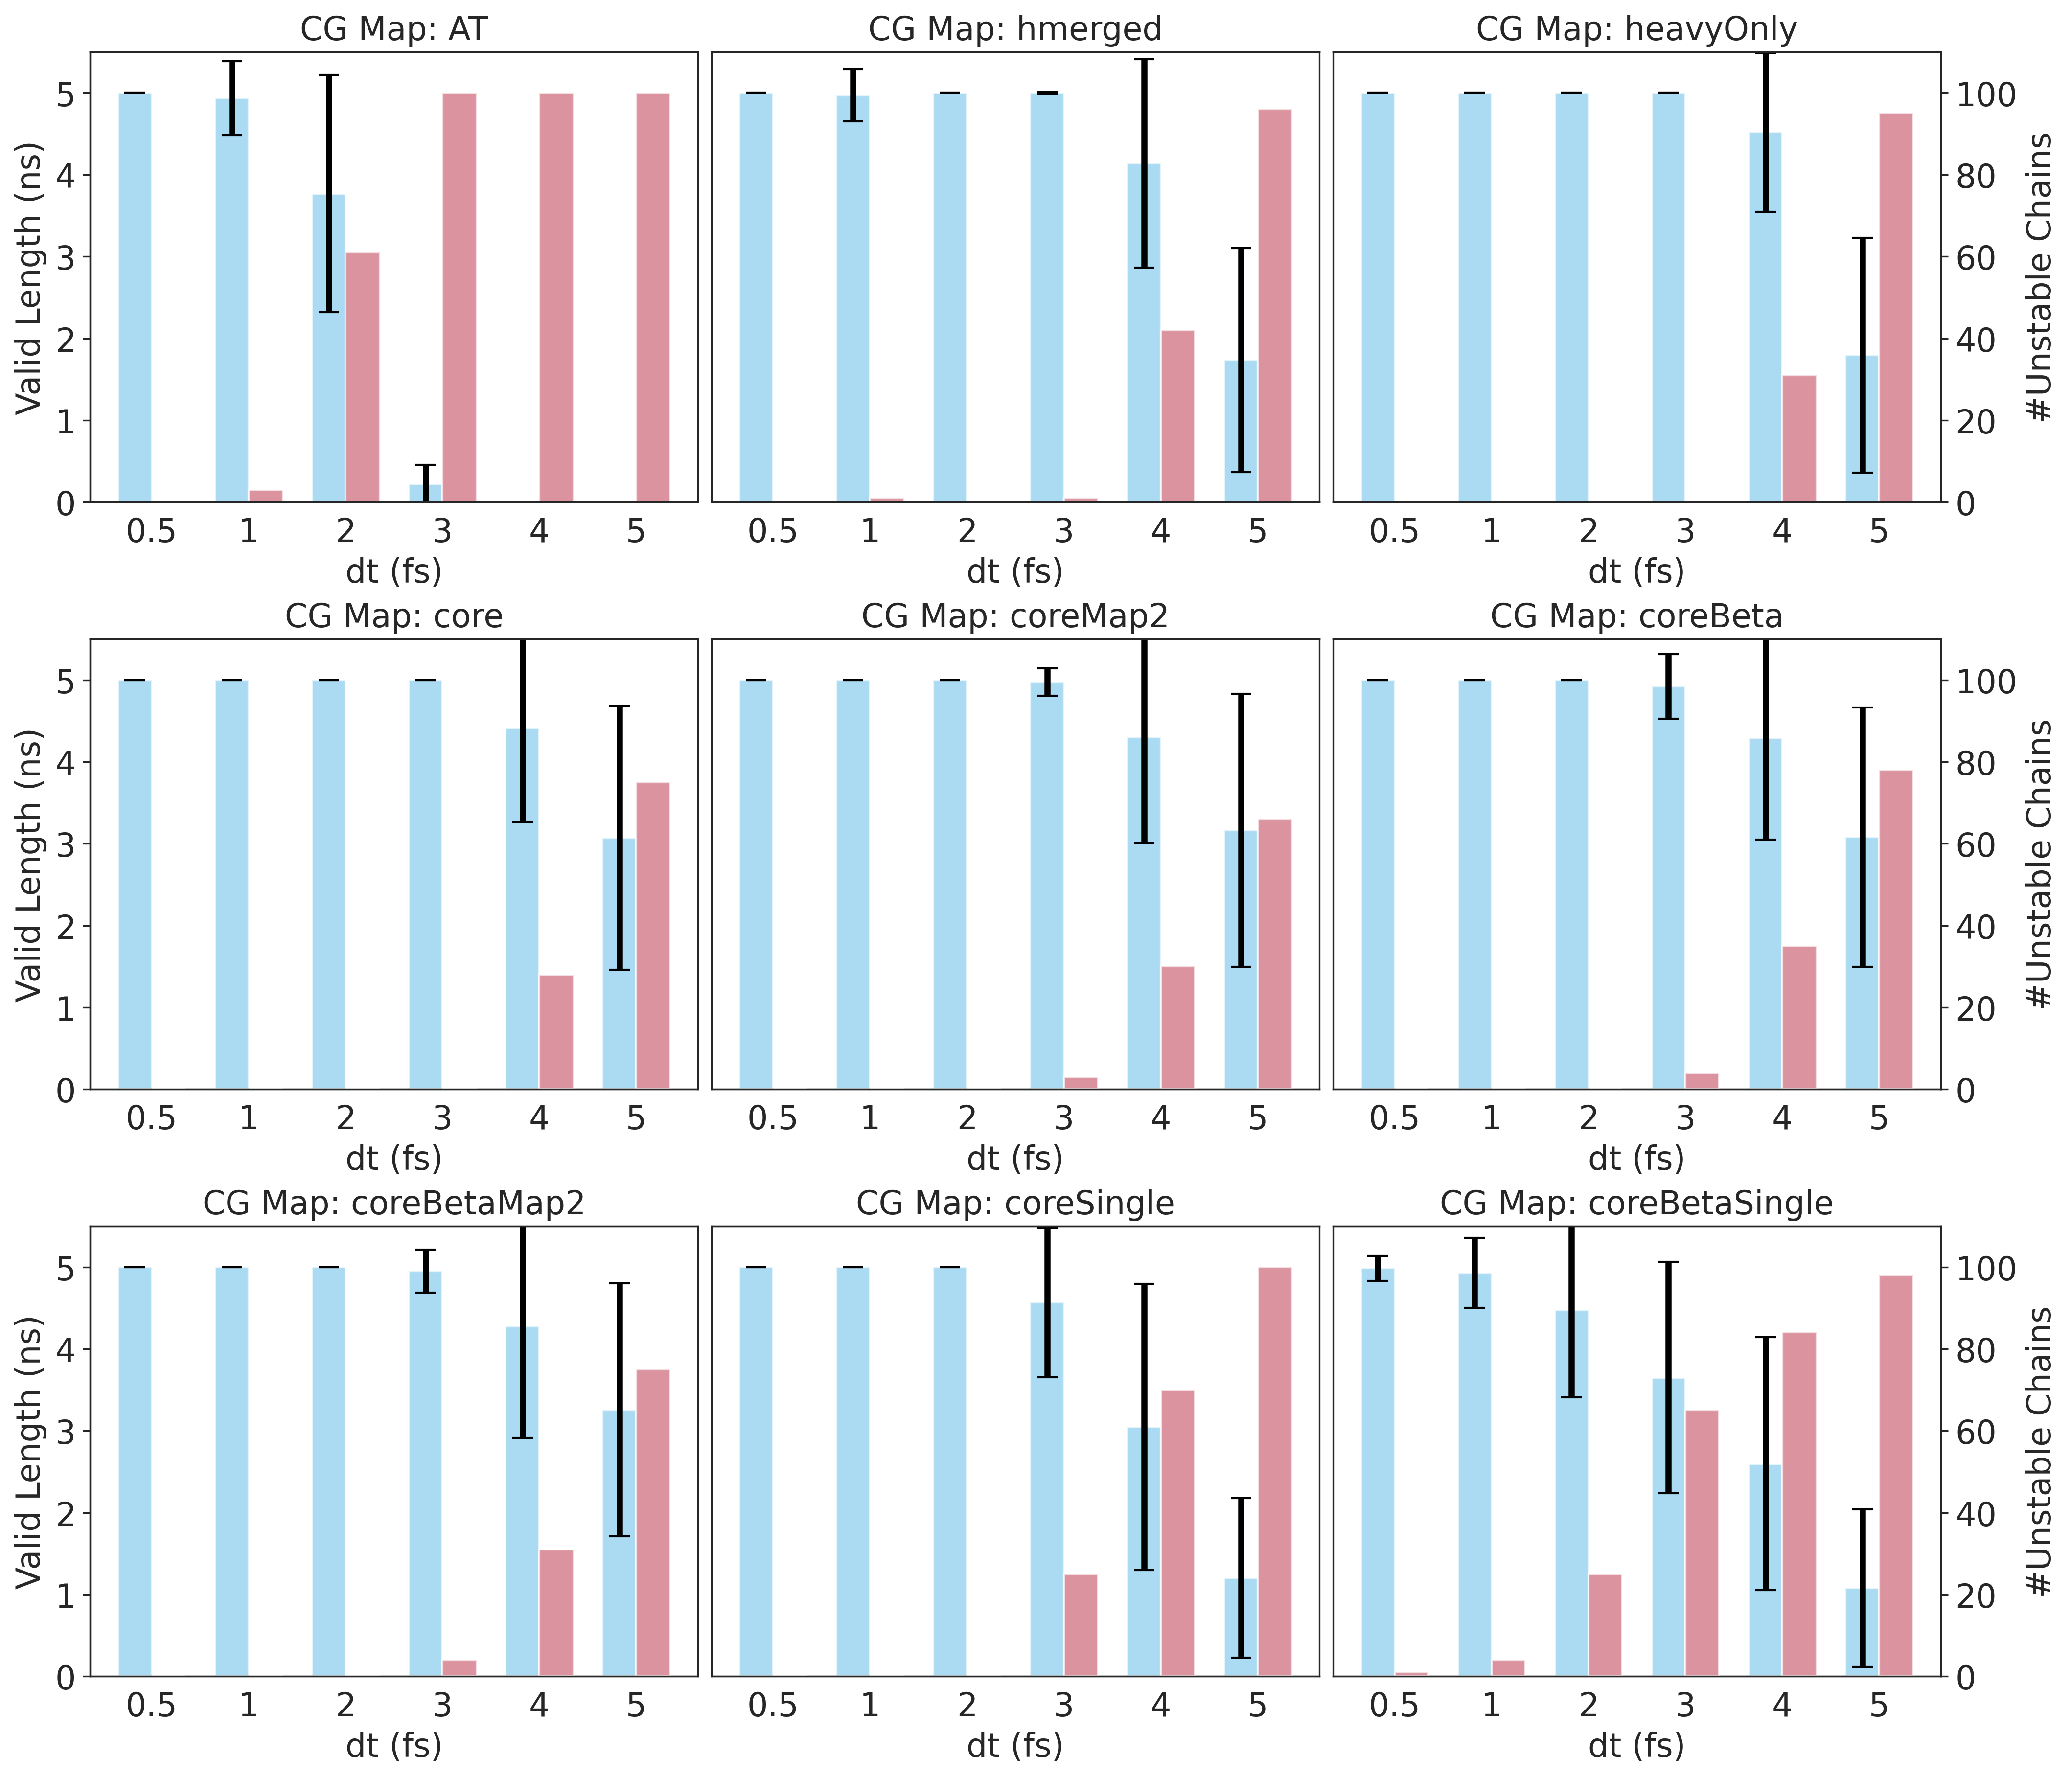

In [23]:
data = {
    'AT': {
        'dt': [0.5, 1, 2, 3, 4, 5],
        'mean': [5000.0, 4936.5, 3768.1, 223.0, 2.7, 1.7],
        'std': [0.0, 451.2, 1450.2, 234.9, 0.9, 0.6],
        'n_exploded': [0, 3, 61, 100, 100, 100]
    },
    'hmerged': {
        'dt': [0.5, 1, 2, 3, 4, 5],
        'mean': [5000.0, 4967.9, 5000.0, 4998.8, 4136.2, 1734.1],
        'std': [0.0, 319.6, 0.0, 11.8, 1271.9, 1367.1],
        'n_exploded': [0, 1, 0, 1, 42, 96]
    },
    'heavyOnly': {
        'dt': [0.5, 1, 2, 3, 4, 5],
        'mean': [5000.0, 5000.0, 5000.0, 5000.0, 4518.1, 1793.2],
        'std': [0.0, 0.0, 0.0, 0.0, 969.7, 1432.8],
        'n_exploded': [0, 0, 0, 0, 31, 95]
    },
    'core': {
        'dt': [0.5, 1, 2, 3, 4, 5],
        'mean': [5000.0, 5000.0, 5000.0, 5000.0, 4418.2, 3068.8],
        'std': [0.0, 0.0, 0.0, 0.0, 1152.9, 1609.8],
        'n_exploded': [0, 0, 0, 0, 28, 75]
    },
    'coreMap2': {
        'dt': [0.5, 1, 2, 3, 4, 5],
        'mean': [5000.0, 5000.0, 5000.0, 4972.1, 4295.8, 3162.6],
        'std': [0.0, 0.0, 0.0, 167.2, 1287.3, 1669.0],
        'n_exploded': [0, 0, 0, 3, 30, 66]
    },
    'coreBeta': {
        'dt': [0.5, 1, 2, 3, 4, 5],
        'mean': [5000.0, 5000.0, 5000.0, 4920.2, 4294.1, 3080.4],
        'std': [0.0, 0.0, 0.0, 394.3, 1246.7, 1584.7],
        'n_exploded': [0, 0, 0, 4, 35, 78]
    },
    'coreBetaMap2': {
        'dt': [0.5, 1, 2, 3, 4, 5],
        'mean': [5000.0, 5000.0, 5000.0, 4952.3, 4273.8, 3255.0],
        'std': [0.0, 0.0, 0.0, 262.5, 1359.3, 1543.7],
        'n_exploded': [0, 0, 0, 4, 31, 75]
    },
    'coreSingle': {
        'dt': [0.5, 1, 2, 3, 4, 5],
        'mean': [5000.0, 5000.0, 5000.0, 4568.5, 3047.6, 1204.2],
        'std': [0.0, 0.0, 0.0, 912.7, 1748.9, 973.5],
        'n_exploded': [0, 0, 0, 25, 70, 100]
    },
    'coreBetaSingle': {
        'dt': [0.5, 1, 2, 3, 4, 5],
        'mean': [4984.8, 4929.1, 4471.2, 3649.1, 2597.2, 1078.5],
        'std': [151.6, 428.0, 1060.9, 1413.1, 1543.3, 961.3],
        'n_exploded': [1, 4, 25, 65, 84, 98]
    }
}

# Plotting
cg_maps = list(data.keys())
num_maps = len(cg_maps)
cols = 3
rows = int(np.ceil(num_maps / cols))

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), constrained_layout=True)
axes = axes.flatten()
ax_pairs = []  # store (ax1, ax2) pairs

for i, cg_map in enumerate(cg_maps):
    ax1 = axes[i]
    map_data = data[cg_map]
    
    dts = map_data['dt']
    means = np.array(map_data['mean'])/1000.0  # Convert to ns
    stds = np.array(map_data['std'])/1000.0    # Convert to ns
    n_exploded = map_data['n_exploded']
    
    x = np.arange(len(dts))
    width = 0.35
    
    # Plot Mean Valid Frames on left axis
    color = "#88CCEE"
    rects1 = ax1.bar(x - width/2, means, width, yerr=stds, label='Valid Length (ns)', color=color, alpha=0.7, capsize=5)
    ax1.set_ylabel('Valid Length (ns)')
    ax1.tick_params(axis='y')
    ax1.set_xticks(x)
    ax1.set_xticklabels([str(d) for d in dts])
    ax1.set_xlabel('dt (fs)')
    ax1.set_title(f'CG Map: {cg_map}')
    ax1.set_ylim(0, 5.5) # Standardize y-axis for better comparison

    # Create a second y-axis for N Exploded Chains
    ax2 = ax1.twinx()
    color = '#CC6677'
    rects2 = ax2.bar(x + width/2, n_exploded, width, label='N Exploded Chains', color=color, alpha=0.7)
    ax2.set_ylabel('#Unstable Chains')
    ax2.tick_params(axis='y')
    ax2.set_ylim(0, 110) # Max is 100

    # Add legend
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    # ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right') # upper left might cover data for high validity
    ax_pairs.append((ax1, ax2))
    
# Hide unused subplots
for i in range(num_maps, len(axes)):
    axes[i].axis('off')
    
for r in range(rows):
    start = r * cols
    end = min(start + cols, len(ax_pairs))
    row_axes = ax_pairs[start:end]

    for j, (ax1, ax2) in enumerate(row_axes):
        if j != 0:  # not leftmost
            ax1.yaxis.set_visible(False)
            ax1.spines['left'].set_visible(False)
        if j != len(row_axes) - 1:  # not rightmost
            ax2.yaxis.set_visible(False)
            ax2.spines['right'].set_visible(False)
    
plt.savefig('Amino_acids/ala2_cg_map_stability_comparison_NVE.pdf')

# Pro2

In [33]:
import importlib
# --- Dihedral analysis for Pro2 ---
importlib.reload(dataset)
Pro2_Dataset = dataset.Pro2_Dataset()
Pro2_Dataset.coarse_grain('heavyOnly')
# Prepare reference coordinates for Pro2
Ref_coords_AT_pro2 = jnp.concatenate([
    jnp.array(Pro2_Dataset.dataset_U['training']['R']),
    jnp.array(Pro2_Dataset.dataset_U['validation']['R']),
    jnp.array(Pro2_Dataset.dataset_U['testing']['R'])
], axis=0)
Ref_coords_heavyOnly_pro2 = jnp.concatenate([
    jnp.array(Pro2_Dataset.cg_dataset_U['training']['R']),
    jnp.array(Pro2_Dataset.cg_dataset_U['validation']['R']),
    jnp.array(Pro2_Dataset.cg_dataset_U['testing']['R'])
], axis=0)

atom_pairs = [(1,3),(3,7),(7,8),(8,10)]
# Initialize lists to store results
heavyAtom_means = []
stds = []
# Compute distances for each pair
for pair in atom_pairs:
    distances = utils.compute_atom_distance(Ref_coords_heavyOnly_pro2, pair[0], pair[1], Pro2_Dataset.displacement_fn_U)
    heavyAtom_mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    heavyAtom_means.append(heavyAtom_mean_distance)
    stds.append(std_distance)
    print(f"HeavyAtom Ref pair {pair}: Mean = {heavyAtom_mean_distance:.3f}, Std = {std_distance:.3f}")

pro2_heavy_distance_filter = utils.setup_distance_filter_fn(heavyAtom_means, Pro2_Dataset.displacement_fn_U, delta=0.05)

Loading pro2 dataset from: /home/franz/l-pro2_ttot=500ns_dt=0.5fs_nstxout=2000.npz
Original positions: 0.0 to 3.4190003871917725
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.4190003871917725
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.4190003871917725
Scale dataset by 1 for R and 1 for U.
Training set size: 350000
Validation set size: 50000
Original positions: 0.0 to 3.4179999828338623
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.4179999828338623
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.4179999828338623
Scale dataset by 1 for R and 1 for U.
HeavyAtom Ref pair (1, 3): Mean = 0.135, Std = 0.002
HeavyAtom Ref pair (3, 7): Mean = 0.147, Std = 0.003
HeavyAtom Ref pair (7, 8): Mean = 0.155, Std = 0.003
HeavyAtom Ref pair (8, 10): Mean = 0.134, Std = 0.002


In [41]:
cg_results = {}

Ref_coords = {
    'heavyOnly': Ref_coords_heavyOnly_pro2,
}

maps = {
    'core': ([0,1,2,3], [1,2,3,4], [(0,1),(1,2),(2,3),(3,4)], 'heavyOnly'),
    'coreMap2': ([0,1,2,3], [1,2,3,4], [(0,1),(1,2),(2,3),(3,4)], 'heavyOnly'),
    'coreBeta': ([0,1,3,4], [1,3,4,5], [(0,1),(1,3),(3,4),(4,5)], 'heavyOnly'),
    'coreBetaMap2': ([0,1,3,4], [1,3,4,5], [(0,1),(1,3),(3,4),(4,5)], 'heavyOnly'),
}

for cgmap, base_path in {
    "core": '/home/franz/CG-Mapping-Benchmark/Amino_acids/capped_pro/Pro2_map=core/simulation_NVT',
    "coreMap2": '/home/franz/CG-Mapping-Benchmark/Amino_acids/capped_pro/Pro2_map=coreMap2/simulation_NVT',
    "coreBeta": '/home/franz/CG-Mapping-Benchmark/Amino_acids/capped_pro/Pro2_map=coreBeta/simulation_NVT',
    "coreBetaMap2": '/home/franz/CG-Mapping-Benchmark/Amino_acids/capped_pro/Pro2_map=coreBetaMap2/simulation_NVT',
}.items():
    cg_names = []
    cg_coords = []
    cg_kTs = []
    cg_epots = []
    cg_etots = []
    cg_forces = []
    dt_values_fs = [2]
    t_eq = 0
    t_tot = 5000
    print(f"\n Processing CG map: {cgmap}")

    phi_idcs, psi_idcs, core_bond_idcs, ref_name = maps[cgmap]

    for dt in dt_values_fs:
        name = f"mol=pro2_dt=2_teq=0_t=5000_nmol=1_nchains=100_mode=sampling_seed=22"
        cg_path = f'{base_path}/traj_{name}'
        aux_path = os.path.join(cg_path, 'traj_state_aux.pkl')
        traj_path = os.path.join(cg_path, 'trajectory.pkl')

        traj_aux = pkl.load(open(aux_path, 'rb'))
        traj = pkl.load(open(traj_path, 'rb'))

        traj_coords = np.array(traj)
        traj_force = traj_aux['force']
        traj_kT = traj_aux['kT']
        traj_epot = traj_aux['epot']
        traj_etot = traj_aux['etot']

        # Apply distance filtering
        filter_fn = pro2_heavy_distance_filter
        traj_coords = utils.split_into_chains(traj_coords, line_locs)
        print('traj shape before filtering:', traj_coords.shape)
        traj_coords, combined_mask = filter_fn(
            traj_coords,
            indices=core_bond_idcs
        )
        # reshape mask and traj back to (n_chains*n_frames, ...)
        n_chains, n_frames, n_atoms, _ = traj_coords.shape
        traj_coords = traj_coords.reshape((n_chains * n_frames, n_atoms, 3))
        combined_mask = combined_mask.reshape((n_chains * n_frames,))
        
        traj_force = traj_force[combined_mask]
        traj_kT = traj_kT[combined_mask]
        traj_epot = traj_epot[combined_mask]
        traj_etot = traj_etot[combined_mask]
            
        cg_names.append(name)
        cg_kTs.append(traj_kT)
        cg_epots.append(traj_epot)
        cg_coords.append(traj_coords)
        cg_etots.append(traj_etot)
        cg_forces.append(traj_force)

        cg_results[cgmap] = {
        "names": cg_names,
        "coords": cg_coords,
        "forces": cg_forces,
        "kTs": cg_kTs,
        "epots": cg_epots,
        "etots": cg_etots,
        "dt_values_fs": dt_values_fs,
        "t_eq": t_eq,
        "t_tot": t_tot,
        "base_path": base_path,
        "phi_idcs": phi_idcs,
        "psi_idcs": psi_idcs,
        "core_bond_idcs": core_bond_idcs,
        "ref_name": ref_name
        }



 Processing CG map: core
traj shape before filtering: (100, 10000, 5, 3)
Input shape: (100, 10000, 5, 3)
>> Processed shape: (100, 10000, 5, 3)
>> Valid frames per chain ns 5000.0 ± 0.0
>> Chains with at least one invalid frame: 0/100

 Processing CG map: coreMap2
traj shape before filtering: (100, 10000, 5, 3)
Input shape: (100, 10000, 5, 3)
>> Processed shape: (100, 10000, 5, 3)
>> Valid frames per chain ns 5000.0 ± 0.0
>> Chains with at least one invalid frame: 0/100

 Processing CG map: coreBeta
traj shape before filtering: (100, 10000, 6, 3)
Input shape: (100, 10000, 6, 3)
>> Processed shape: (100, 10000, 6, 3)
>> Valid frames per chain ns 5000.0 ± 0.0
>> Chains with at least one invalid frame: 0/100

 Processing CG map: coreBetaMap2
traj shape before filtering: (100, 10000, 6, 3)
Input shape: (100, 10000, 6, 3)
>> Processed shape: (100, 10000, 6, 3)
>> Valid frames per chain ns 5000.0 ± 0.0
>> Chains with at least one invalid frame: 0/100


In [42]:
pro2_dihedral_fn_heavyOnly = utils.init_dihedral_fn(Pro2_Dataset.displacement_fn_U, [[1,3,7,8],[3,7,8,10]])
Ref_phi_heavyOnly, Ref_psi_heavyOnly = pro2_dihedral_fn_heavyOnly(jnp.array(Ref_coords_heavyOnly_pro2))
pro2_dihedral_fn_core = utils.init_dihedral_fn(Pro2_Dataset.displacement_fn_U, [[0,1,2,3], [1,2,3,4]])

## Core

In [43]:
import importlib
importlib.reload(utils)

# Use cg_data to get indices and reference coordinates for core mapping
cg_data_core = cg_results['core']
cg_names_core = cg_data_core['names']
cg_coords_core = cg_data_core['coords']
dt_values_core = cg_data_core['dt_values_fs']
phi_idcs_core = cg_data_core['phi_idcs']
psi_idcs_core = cg_data_core['psi_idcs']
ref_name_core = cg_data_core['ref_name']
Ref_coords_core = Ref_coords[ref_name_core]


phis_core, psis_core = [], []
names_core = []
for i in range(len(cg_names_core)):
    phi, psi = pro2_dihedral_fn_core(jnp.array(cg_coords_core[i]))
    phis_core.append(phi)
    psis_core.append(psi)
    names_core.append(f"{dt_values_core[i]} fs")
    

# Use cg_data to get indices and reference coordinates for core mapping
cg_data_core = cg_results['coreMap2']
cg_names_core = cg_data_core['names']
cg_coords_core = cg_data_core['coords']
dt_values_core = cg_data_core['dt_values_fs']
phi_idcs_core = cg_data_core['phi_idcs']
psi_idcs_core = cg_data_core['psi_idcs']
ref_name_core = cg_data_core['ref_name']
Ref_coords_core = Ref_coords[ref_name_core]

# Initialize dihedral function for core mapping
pro2_dihedral_fn_core = utils.init_dihedral_fn(Pro2_Dataset.displacement_fn_U, [phi_idcs_core, psi_idcs_core])

phis_coreMap2, psis_coreMap2 = [], []
names_core = []
for i in range(len(cg_names_core)):
    phi, psi = pro2_dihedral_fn_core(jnp.array(cg_coords_core[i]))
    phis_coreMap2.append(phi)
    psis_coreMap2.append(psi)
    names_core.append(f"{dt_values_core[i]} fs")

## coreBeta

In [44]:
import importlib
importlib.reload(utils)

# Use cg_data to get indices and reference coordinates for coreBeta mapping
cg_data_coreBeta = cg_results['coreBeta']
cg_names_coreBeta = cg_data_coreBeta['names']
cg_coords_coreBeta = cg_data_coreBeta['coords']
dt_values_coreBeta = cg_data_coreBeta['dt_values_fs']
phi_idcs_coreBeta = cg_data_coreBeta['phi_idcs']
psi_idcs_coreBeta = cg_data_coreBeta['psi_idcs']
ref_name_coreBeta = cg_data_coreBeta['ref_name']
Ref_coords_coreBeta = Ref_coords[ref_name_coreBeta]

# Initialize dihedral function for coreBeta mapping
pro2_dihedral_fn_coreBeta = utils.init_dihedral_fn(Pro2_Dataset.displacement_fn_U, [phi_idcs_coreBeta, psi_idcs_coreBeta])

phis_coreBeta, psis_coreBeta = [], []
names_coreBeta = []
for i in range(len(cg_names_coreBeta)):
    phi, psi = pro2_dihedral_fn_coreBeta(jnp.array(cg_coords_coreBeta[i]))
    phis_coreBeta.append(phi)
    psis_coreBeta.append(psi)
    names_coreBeta.append(f"{dt_values_coreBeta[i]} fs")

In [45]:
import importlib
importlib.reload(utils)

# Use cg_data to get indices and reference coordinates for coreBeta mapping
cg_data_coreBeta = cg_results['coreBetaMap2']
cg_names_coreBeta = cg_data_coreBeta['names']
cg_coords_coreBeta = cg_data_coreBeta['coords']
dt_values_coreBeta = cg_data_coreBeta['dt_values_fs']
phi_idcs_coreBeta = cg_data_coreBeta['phi_idcs']
psi_idcs_coreBeta = cg_data_coreBeta['psi_idcs']
ref_name_coreBeta = cg_data_coreBeta['ref_name']
Ref_coords_coreBeta = Ref_coords[ref_name_coreBeta]

# Initialize dihedral function for coreBeta mapping
pro2_dihedral_fn_coreBeta = utils.init_dihedral_fn(Pro2_Dataset.displacement_fn_U, [phi_idcs_coreBeta, psi_idcs_coreBeta])

phis_coreBetaMap2, psis_coreBetaMap2 = [], []
names_coreBeta = []
for i in range(len(cg_names_coreBeta)):
    phi, psi = pro2_dihedral_fn_coreBeta(jnp.array(cg_coords_coreBeta[i]))
    phis_coreBetaMap2.append(phi)
    psis_coreBetaMap2.append(psi)
    names_coreBeta.append(f"{dt_values_coreBeta[i]} fs")

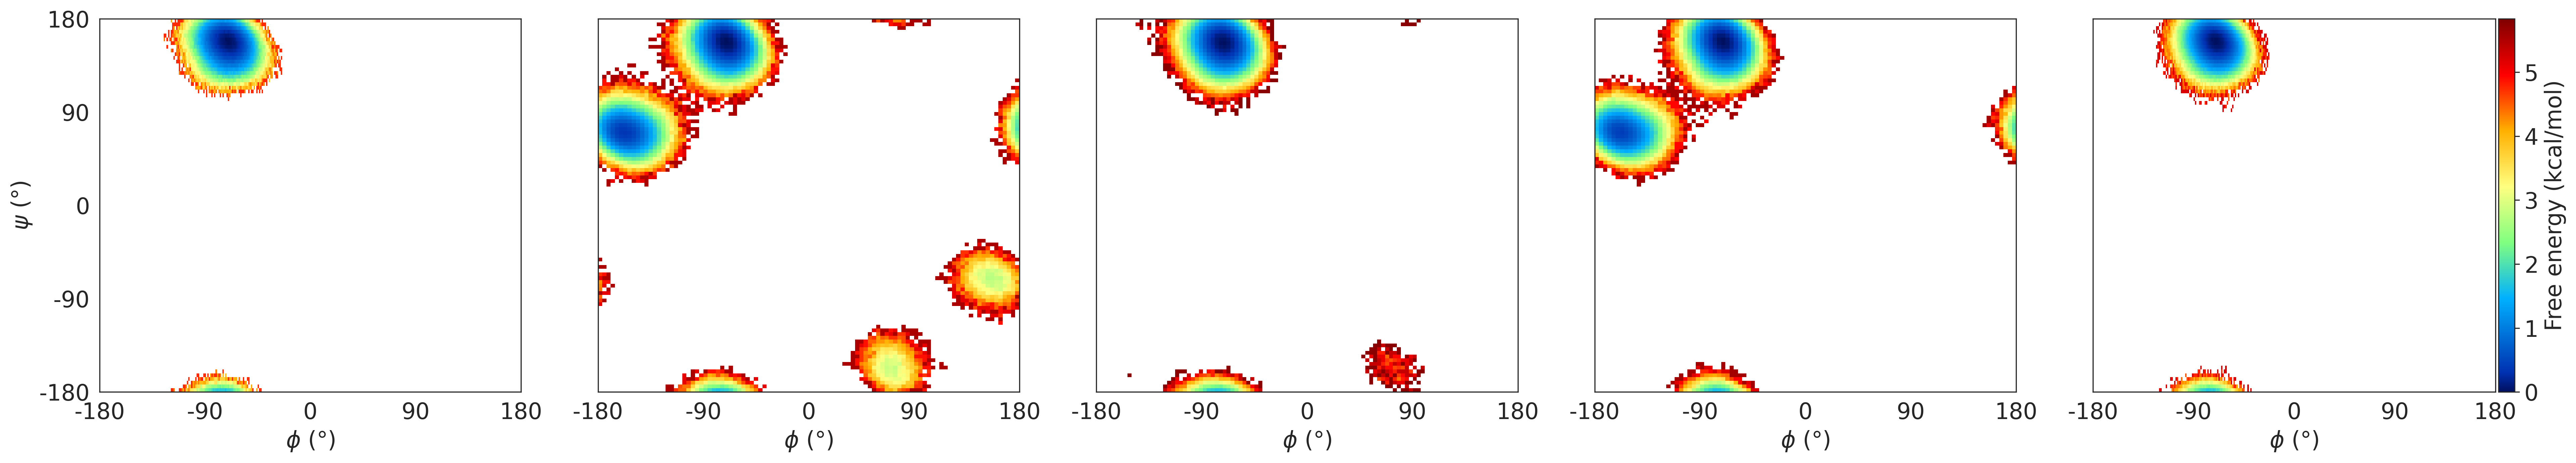

In [46]:
import importlib 
importlib.reload(utils)

fig, axes = plt.subplots(1, 5, figsize=(26, 5))
axes = axes.flatten()

bins = 100

def filter_finite(phi, psi):
	mask = np.isfinite(phi) & np.isfinite(psi)
	return phi[mask], psi[mask]


phis = [Ref_phi_heavyOnly, phis_core[0], phis_coreMap2[0], phis_coreBeta[0], phis_coreBetaMap2[0]]
psis = [Ref_psi_heavyOnly, psis_core[0], psis_coreMap2[0], psis_coreBeta[0], psis_coreBetaMap2[0]]

for i in range(len(phis)):
	phis[i], psis[i] = filter_finite(phis[i], psis[i])

scale_used = utils.determine_free_energy_scale(phis, psis, 300. * quantity.kb, bins=bins)

utils.plot_histogram_free_energy(axes[1], phis[1], psis[1], 300. * quantity.kb, scale=scale_used, bins=bins, show_yticks=False,)

utils.plot_histogram_free_energy(axes[2], phis[2], psis[2], 300. * quantity.kb, legend=False, show_yticks=False, scale=scale_used, bins=bins)

utils.plot_histogram_free_energy(axes[3], phis[3], psis[3], 300. * quantity.kb, show_ylabel=False, scale=scale_used, bins=bins, show_yticks=False,)

utils.plot_histogram_free_energy(axes[4], phis[4], psis[4], 300. * quantity.kb, scale=scale_used, bins=bins, show_yticks=False,legend=True)

utils.plot_histogram_free_energy(axes[0], Ref_phi_heavyOnly, Ref_psi_heavyOnly, 300. * quantity.kb, scale=scale_used, bins=bins, show_yticks=True,show_ylabel=True,)

plt.tight_layout()
plt.savefig('Amino_acids/pro2_low_res_comparison.pdf')

# Gly2

In [48]:
import importlib

importlib.reload(dataset)
Gly2_Dataset = dataset.Gly2_Dataset()
Gly2_Dataset.coarse_grain('heavyOnly')

# Prepare reference coordinates for Gly2
Ref_coords_AT_gly2 = jnp.concatenate([
    jnp.array(Gly2_Dataset.dataset_U['training']['R']),
    jnp.array(Gly2_Dataset.dataset_U['validation']['R']),
    jnp.array(Gly2_Dataset.dataset_U['testing']['R'])
], axis=0)

Ref_coords_heavyOnly_gly2 = jnp.concatenate([
    jnp.array(Gly2_Dataset.cg_dataset_U['training']['R']),
    jnp.array(Gly2_Dataset.cg_dataset_U['validation']['R']),
    jnp.array(Gly2_Dataset.cg_dataset_U['testing']['R'])
], axis=0)

atom_pairs = [(1,3),(3,4),(4,5),(5,7)]
# Initialize lists to store results
heavyAtom_means = []
stds = []
# Compute distances for each pair
for pair in atom_pairs:
    distances = utils.compute_atom_distance(Ref_coords_heavyOnly_gly2, pair[0], pair[1], Gly2_Dataset.displacement_fn_U)
    heavyAtom_mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    heavyAtom_means.append(heavyAtom_mean_distance)
    stds.append(std_distance)
    print(f"HeavyAtom Ref pair {pair}: Mean = {heavyAtom_mean_distance:.3f}, Std = {std_distance:.3f}")

gly2_heavy_distance_filter = utils.setup_distance_filter_fn(heavyAtom_means, Gly2_Dataset.displacement_fn_U, delta=0.05)

Loading gly2 dataset from: /home/franz/l-gly2_ttot=500ns_dt=0.5fs_nstxout=2000.npz
Original positions: 0.0 to 3.1410000324249268
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.1410000324249268
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.1410000324249268
Scale dataset by 1 for R and 1 for U.
Training set size: 350000
Validation set size: 50000
Original positions: 0.0 to 3.140000104904175
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.140000104904175
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.140000104904175
Scale dataset by 1 for R and 1 for U.
HeavyAtom Ref pair (1, 3): Mean = 0.133, Std = 0.002
HeavyAtom Ref pair (3, 4): Mean = 0.147, Std = 0.003
HeavyAtom Ref pair (4, 5): Mean = 0.154, Std = 0.003
HeavyAtom Ref pair (5, 7): Mean = 0.134, Std = 0.002


In [54]:
cg_results = {}

Ref_coords = {
    'heavyOnly': Ref_coords_heavyOnly_gly2,
}

maps = {
    'core': ([0,1,2,3], [1,2,3,4], [(0,1),(1,2),(2,3),(3,4)], 'heavyOnly'),
    'coreMap2': ([0,1,2,3], [1,2,3,4], [(0,1),(1,2),(2,3),(3,4)], 'heavyOnly'),
}

for cgmap, base_path in {
    "core": 'Amino_acids/capped_gly/Gly2_map=core/simulation_NVT',
    "coreMap2": 'Amino_acids/capped_gly/Gly2_map=coreMap2/simulation_NVT',
}.items():
    cg_names = []
    cg_coords = []
    cg_kTs = []
    cg_epots = []
    cg_etots = []
    cg_forces = []
    dt_values_fs = [2]
    t_eq = 0
    t_tot = 5000
    print(f"\n Processing CG map: {cgmap}")

    phi_idcs, psi_idcs, core_bond_idcs, ref_name = maps[cgmap]

    for dt in dt_values_fs:
        name = f"mol=gly2_dt=2_teq=0_t=5000_nmol=1_nchains=100_mode=sampling_seed=22"
        cg_path = f'{base_path}/traj_{name}'
        aux_path = os.path.join(cg_path, 'traj_state_aux.pkl')
        traj_path = os.path.join(cg_path, 'trajectory.pkl')

        traj_aux = pkl.load(open(aux_path, 'rb'))
        traj = pkl.load(open(traj_path, 'rb'))

        traj_coords = np.array(traj)
        traj_force = traj_aux['force']
        traj_kT = traj_aux['kT']
        traj_epot = traj_aux['epot']
        traj_etot = traj_aux['etot']

        # Apply distance filtering
        filter_fn = gly2_heavy_distance_filter
        traj_coords = utils.split_into_chains(traj_coords, line_locs)
        print('traj shape before filtering:', traj_coords.shape)
        traj_coords, combined_mask = filter_fn(
            traj_coords,
            indices=core_bond_idcs
        )
        # reshape mask and traj back to (n_chains*n_frames, ...)
        n_chains, n_frames, n_atoms, _ = traj_coords.shape
        traj_coords = traj_coords.reshape((n_chains * n_frames, n_atoms, 3))
        combined_mask = combined_mask.reshape((n_chains * n_frames,))
        
        traj_force = traj_force[combined_mask]
        traj_kT = traj_kT[combined_mask]
        traj_epot = traj_epot[combined_mask]
        traj_etot = traj_etot[combined_mask]

        cg_names.append(name)
        cg_kTs.append(traj_kT)
        cg_epots.append(traj_epot)
        cg_coords.append(traj_coords)
        cg_etots.append(traj_etot)
        cg_forces.append(traj_force)

        cg_results[cgmap] = {
        "names": cg_names,
        "coords": cg_coords,
        "forces": cg_forces,
        "kTs": cg_kTs,
        "epots": cg_epots,
        "etots": cg_etots,
        "dt_values_fs": dt_values_fs,
        "t_eq": t_eq,
        "t_tot": t_tot,
        "base_path": base_path,
        "phi_idcs": phi_idcs,
        "psi_idcs": psi_idcs,
        "core_bond_idcs": core_bond_idcs,
        "ref_name": ref_name
        }



 Processing CG map: core
traj shape before filtering: (100, 10000, 5, 3)
Input shape: (100, 10000, 5, 3)
>> Processed shape: (100, 10000, 5, 3)
>> Valid frames per chain ns 4839.7 ± 697.1
>> Chains with at least one invalid frame: 7/100

 Processing CG map: coreMap2
traj shape before filtering: (100, 10000, 5, 3)
Input shape: (100, 10000, 5, 3)
>> Processed shape: (100, 10000, 5, 3)
>> Valid frames per chain ns 5000.0 ± 0.0
>> Chains with at least one invalid frame: 0/100


In [55]:
gly2_dihedral_fn_heavyOnly = utils.init_dihedral_fn(Gly2_Dataset.displacement_fn_U, [[1,3,4,5],[3,4,5,7]])
Ref_phi_heavyOnly, Ref_psi_heavyOnly = gly2_dihedral_fn_heavyOnly(Ref_coords_heavyOnly_gly2)

## Core

In [56]:
import importlib
importlib.reload(utils)

# Use cg_data to get indices and reference coordinates for core mapping (Gly2)
cg_data_core = cg_results['core']
cg_names_core = cg_data_core['names']
cg_coords_core = cg_data_core['coords']
dt_values_core = cg_data_core['dt_values_fs']
phi_idcs_core = cg_data_core['phi_idcs']
psi_idcs_core = cg_data_core['psi_idcs']
ref_name_core = cg_data_core['ref_name']
Ref_coords_core = Ref_coords[ref_name_core]

# Initialize dihedral function for core mapping (Gly2)
gly2_dihedral_fn_core = utils.init_dihedral_fn(Gly2_Dataset.displacement_fn_U, [phi_idcs_core, psi_idcs_core])

phis_core, psis_core = [], []
names_core = []
for i in range(len(cg_names_core)):
    phi, psi = gly2_dihedral_fn_core(jnp.array(cg_coords_core[i]))
    phis_core.append(phi)
    psis_core.append(psi)
    names_core.append(f"{dt_values_core[i]} fs")


In [57]:
# Use cg_data to get indices and reference coordinates for coreMap2 mapping (Gly2)
cg_data_coreMap2 = cg_results['coreMap2']
cg_names_coreMap2 = cg_data_coreMap2['names']
cg_coords_coreMap2 = cg_data_coreMap2['coords']
dt_values_coreMap2 = cg_data_coreMap2['dt_values_fs']
phi_idcs_coreMap2 = cg_data_coreMap2['phi_idcs']
psi_idcs_coreMap2 = cg_data_coreMap2['psi_idcs']
ref_name_coreMap2 = cg_data_coreMap2['ref_name']
Ref_coords_coreMap2 = Ref_coords[ref_name_coreMap2]

# Initialize dihedral function for coreMap2 mapping (Gly2)
gly2_dihedral_fn_coreMap2 = utils.init_dihedral_fn(Gly2_Dataset.displacement_fn_U, [phi_idcs_coreMap2, psi_idcs_coreMap2])

phis_coreMap2, psis_coreMap2 = [], []
names_coreMap2 = []
for i in range(len(cg_names_coreMap2)):
    phi, psi = gly2_dihedral_fn_coreMap2(jnp.array(cg_coords_coreMap2[i]))    
    phis_coreMap2.append(phi)
    psis_coreMap2.append(psi)
    names_coreMap2.append(f"{dt_values_coreMap2[i]} fs")

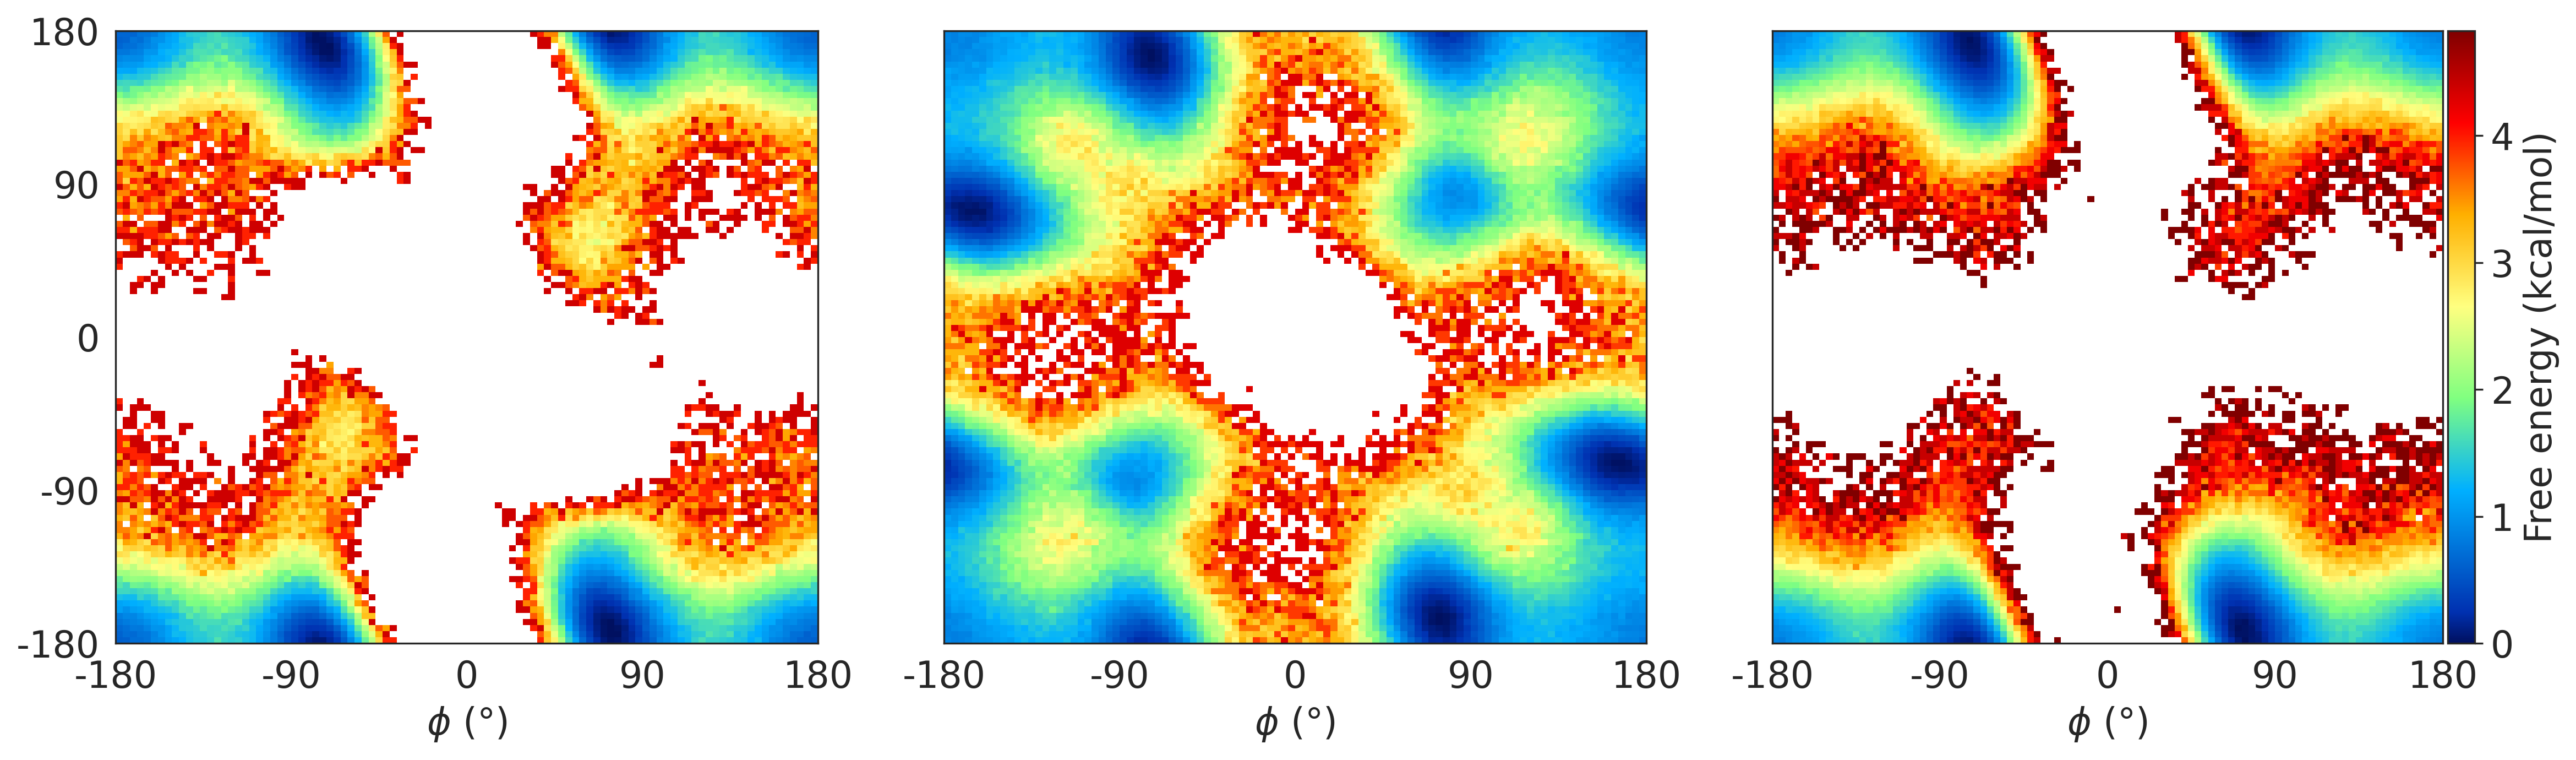

In [58]:
import importlib 
importlib.reload(utils)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes = axes.flatten()

bins = 100

def filter_finite(phi, psi):
	mask = np.isfinite(phi) & np.isfinite(psi)
	return phi[mask], psi[mask]


phis = [Ref_phi_heavyOnly, phis_core[0], phis_coreMap2[0]]
psis = [Ref_psi_heavyOnly, psis_core[0], psis_coreMap2[0]]

for i in range(len(phis)):
	phis[i], psis[i] = filter_finite(phis[i], psis[i])

scale_used = utils.determine_free_energy_scale(phis, psis, 300. * quantity.kb, bins=bins)

utils.plot_histogram_free_energy(axes[2], phis[2], psis[2], 300. * quantity.kb, scale=scale_used, bins=bins, show_yticks=False, legend=True)

utils.plot_histogram_free_energy(axes[1], phis[1], psis[1], 300. * quantity.kb, show_ylabel=False, scale=scale_used, bins=bins, show_yticks=False)

utils.plot_histogram_free_energy(axes[0], phis[0], psis[0], 300. * quantity.kb, scale=scale_used, bins=bins, show_yticks=True,)

plt.tight_layout()
plt.savefig('Amino_acids/gly2_low_res_comparison.pdf')


# Thr2


In [59]:
import importlib
# --- Dihedral analysis for Thr2 ---
importlib.reload(dataset)
Thr2_Dataset = dataset.Thr2_Dataset()
Thr2_Dataset.coarse_grain('heavyOnly')

# Prepare reference coordinates for Thr2
Ref_coords_AT_thr2 = jnp.concatenate([
    jnp.array(Thr2_Dataset.dataset_U['training']['R']),
    jnp.array(Thr2_Dataset.dataset_U['validation']['R']),
    jnp.array(Thr2_Dataset.dataset_U['testing']['R'])
], axis=0)

Ref_coords_heavyOnly_thr2 = jnp.concatenate([
    jnp.array(Thr2_Dataset.cg_dataset_U['training']['R']),
    jnp.array(Thr2_Dataset.cg_dataset_U['validation']['R']),
    jnp.array(Thr2_Dataset.cg_dataset_U['testing']['R'])
], axis=0)

atom_pairs = [(1,3),(3,4),(4,8),(8,10)]
# Initialize lists to store results
heavyAtom_means = []
stds = []
# Compute distances for each pair
for pair in atom_pairs:
    distances = utils.compute_atom_distance(Ref_coords_heavyOnly_thr2, pair[0], pair[1], Thr2_Dataset.displacement_fn_U)
    heavyAtom_mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    heavyAtom_means.append(heavyAtom_mean_distance)
    stds.append(std_distance)
    print(f"HeavyAtom Ref pair {pair}: Mean = {heavyAtom_mean_distance:.3f}, Std = {std_distance:.3f}")

thr2_heavy_distance_filter = utils.setup_distance_filter_fn(heavyAtom_means, Thr2_Dataset.displacement_fn_U, delta=0.05)

Loading thr2 dataset from: /home/franz/l-thr2_ttot=500ns_dt=0.5fs_nstxout=2000.npz
Original positions: 0.0 to 3.1470000743865967
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.1470000743865967
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.1470000743865967
Scale dataset by 1 for R and 1 for U.
Training set size: 350000
Validation set size: 50000
Original positions: 0.0 to 3.1460001468658447
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.1460001468658447
Scale dataset by 1 for R and 1 for U.
Original positions: 0.0 to 3.1460001468658447
Scale dataset by 1 for R and 1 for U.
HeavyAtom Ref pair (1, 3): Mean = 0.133, Std = 0.002
HeavyAtom Ref pair (3, 4): Mean = 0.148, Std = 0.003
HeavyAtom Ref pair (4, 8): Mean = 0.154, Std = 0.003
HeavyAtom Ref pair (8, 10): Mean = 0.134, Std = 0.002


In [64]:
cg_results = {}

Ref_coords = {
    'heavyOnly': Ref_coords_heavyOnly_thr2,
}

maps = {
    'core': ([0,1,2,3], [1,2,3,4], [(0,1),(1,2),(2,3)], 'heavyOnly'),
    'coreMap2': ([0,1,2,3], [1,2,3,4], [(0,1),(1,2),(2,3)], 'heavyOnly'),
    'coreBeta': ([0,1,2,4], [1,2,4,5], [(0,1),(1,2),(2,3)], 'heavyOnly'),
    'coreBetaMap2': ([0,1,2,4], [1,2,4,5], [(0,1),(1,2),(2,3)], 'heavyOnly'),
}


for cgmap, base_path in {
    "core": 'Amino_acids/capped_thr/Thr2_map=core/simulation_NVT',
    "coreMap2": 'Amino_acids/capped_thr/Thr2_map=coreMap2/simulation_NVT',
    "coreBeta": 'Amino_acids/capped_thr/Thr2_map=coreBeta/simulation_NVT',
    "coreBetaMap2": 'Amino_acids/capped_thr/Thr2_map=coreBetaMap2/simulation_NVT',
}.items():
    cg_names = []
    cg_coords = []
    cg_kTs = []
    cg_epots = []
    cg_etots = []
    cg_forces = []
    dt_values_fs = [2]
    t_eq = 0
    t_tot = 5000
    print(f"\n Processing CG map: {cgmap}")
    phi_idcs, psi_idcs, core_bond_idcs, ref_name = maps[cgmap]

    for dt in dt_values_fs:
        name = f"mol=thr2_dt=2_teq=0_t=5000_nmol=1_nchains=100_mode=sampling_seed=22"
        cg_path = f'{base_path}/traj_{name}'
        aux_path = os.path.join(cg_path, 'traj_state_aux.pkl')
        traj_path = os.path.join(cg_path, 'trajectory.pkl')

        traj_aux = pkl.load(open(aux_path, 'rb'))
        traj = pkl.load(open(traj_path, 'rb'))

        traj_coords = np.array(traj)
        traj_force = traj_aux['force']
        traj_kT = traj_aux['kT']
        traj_epot = traj_aux['epot']
        traj_etot = traj_aux['etot']

        # Apply distance filtering
        filter_fn = thr2_heavy_distance_filter
        traj_coords = utils.split_into_chains(traj_coords, line_locs)
        print('traj shape before filtering:', traj_coords.shape)
        traj_coords, combined_mask = filter_fn(
            traj_coords,
            indices=core_bond_idcs
        )
        # reshape mask and traj back to (n_chains*n_frames, ...)
        n_chains, n_frames, n_atoms, _ = traj_coords.shape
        traj_coords = traj_coords.reshape((n_chains * n_frames, n_atoms, 3))
        combined_mask = combined_mask.reshape((n_chains * n_frames,))
        
        traj_force = traj_force[combined_mask]
        traj_kT = traj_kT[combined_mask]
        traj_epot = traj_epot[combined_mask]
        traj_etot = traj_etot[combined_mask]

        cg_names.append(name)
        cg_kTs.append(traj_kT)
        cg_epots.append(traj_epot)
        cg_coords.append(traj_coords)
        cg_etots.append(traj_etot)
        cg_forces.append(traj_force)

        cg_results[cgmap] = {
        "names": cg_names,
        "coords": cg_coords,
        "forces": cg_forces,
        "kTs": cg_kTs,
        "epots": cg_epots,
        "etots": cg_etots,
        "dt_values_fs": dt_values_fs,
        "t_eq": t_eq,
        "t_tot": t_tot,
        "base_path": base_path,
        "phi_idcs": phi_idcs,
        "psi_idcs": psi_idcs,
        "core_bond_idcs": core_bond_idcs,
        "ref_name": ref_name
        }



 Processing CG map: core
traj shape before filtering: (100, 10000, 5, 3)
Input shape: (100, 10000, 5, 3)
>> Processed shape: (100, 10000, 5, 3)
>> Valid frames per chain ns 2743.8 ± 1720.5
>> Chains with at least one invalid frame: 71/100

 Processing CG map: coreMap2
traj shape before filtering: (100, 10000, 5, 3)
Input shape: (100, 10000, 5, 3)
>> Processed shape: (100, 10000, 5, 3)
>> Valid frames per chain ns 1756.0 ± 1629.5
>> Chains with at least one invalid frame: 89/100

 Processing CG map: coreBeta
traj shape before filtering: (100, 10000, 6, 3)
Input shape: (100, 10000, 6, 3)
>> Processed shape: (100, 10000, 6, 3)
>> Valid frames per chain ns 5000.0 ± 0.0
>> Chains with at least one invalid frame: 0/100

 Processing CG map: coreBetaMap2
traj shape before filtering: (100, 10000, 6, 3)
Input shape: (100, 10000, 6, 3)
>> Processed shape: (100, 10000, 6, 3)
>> Valid frames per chain ns 5000.0 ± 0.0
>> Chains with at least one invalid frame: 0/100


In [65]:
thr2_dihedral_fn_heavyOnly = utils.init_dihedral_fn(Thr2_Dataset.displacement_fn_U, [[1,3,4,8],[3,4,8,10]])
    
Ref_phi_heavyOnly, Ref_psi_heavyOnly = thr2_dihedral_fn_heavyOnly(jnp.array(Ref_coords_heavyOnly_thr2))

## Core

In [66]:
import importlib
importlib.reload(utils)

# Use cg_data to get indices and reference coordinates for core mapping (Thr2)
cg_data_core = cg_results['core']
cg_names_core = cg_data_core['names']
cg_coords_core = cg_data_core['coords']
dt_values_core = cg_data_core['dt_values_fs']
phi_idcs_core = cg_data_core['phi_idcs']
psi_idcs_core = cg_data_core['psi_idcs']
ref_name_core = cg_data_core['ref_name']
Ref_coords_core = Ref_coords[ref_name_core]

# Initialize dihedral function for core mapping (Thr2)
thr2_dihedral_fn_core = utils.init_dihedral_fn(Thr2_Dataset.displacement_fn_U, [phi_idcs_core, psi_idcs_core])

phis_core, psis_core = [], []
names_core = []
for i in range(len(cg_names_core)):
    phi, psi = thr2_dihedral_fn_core(jnp.array(cg_coords_core[i]))
    phis_core.append(phi)
    psis_core.append(psi)
    names_core.append(f"{dt_values_core[i]} fs")

In [67]:
# Use cg_data to get indices and reference coordinates for core mapping (Thr2)
cg_data_core = cg_results['coreMap2']
cg_names_core = cg_data_core['names']
cg_coords_core = cg_data_core['coords']
dt_values_core = cg_data_core['dt_values_fs']
phi_idcs_core = cg_data_core['phi_idcs']
psi_idcs_core = cg_data_core['psi_idcs']
ref_name_core = cg_data_core['ref_name']
Ref_coords_core = Ref_coords[ref_name_core]

# Initialize dihedral function for core mapping (Thr2)
thr2_dihedral_fn_core = utils.init_dihedral_fn(Thr2_Dataset.displacement_fn_U, [phi_idcs_core, psi_idcs_core])

phis_coreMap2, psis_coreMap2 = [], []
names_core = []
for i in range(len(cg_names_core)):
    phi, psi = thr2_dihedral_fn_core(jnp.array(cg_coords_core[i]))
    phis_coreMap2.append(phi)
    psis_coreMap2.append(psi)
    names_core.append(f"{dt_values_core[i]} fs")

## CoreBeta

In [68]:
import importlib
importlib.reload(utils)

# Use cg_data to get indices and reference coordinates for core mapping (Thr2)
cg_data_core = cg_results['coreBeta']
cg_names_core = cg_data_core['names']
cg_coords_core = cg_data_core['coords']
dt_values_core = cg_data_core['dt_values_fs']
phi_idcs_core = cg_data_core['phi_idcs']
psi_idcs_core = cg_data_core['psi_idcs']
ref_name_core = cg_data_core['ref_name']
Ref_coords_core = Ref_coords[ref_name_core]

# Initialize dihedral function for core mapping (Thr2)
thr2_dihedral_fn_core = utils.init_dihedral_fn(Thr2_Dataset.displacement_fn_U, [phi_idcs_core, psi_idcs_core])

phis_coreBeta, psis_coreBeta = [], []
names_core = []
for i in range(len(cg_names_core)):
    phi, psi = thr2_dihedral_fn_core(jnp.array(cg_coords_core[i]))
    phis_coreBeta.append(phi)
    psis_coreBeta.append(psi)
    names_core.append(f"{dt_values_core[i]} fs")

In [69]:
import importlib
importlib.reload(utils)

# Use cg_data to get indices and reference coordinates for core mapping (Thr2)
cg_data_core = cg_results['coreBetaMap2']
cg_names_core = cg_data_core['names']
cg_coords_core = cg_data_core['coords']
dt_values_core = cg_data_core['dt_values_fs']
phi_idcs_core = cg_data_core['phi_idcs']
psi_idcs_core = cg_data_core['psi_idcs']
ref_name_core = cg_data_core['ref_name']
Ref_coords_core = Ref_coords[ref_name_core]

# Initialize dihedral function for core mapping (Thr2)
thr2_dihedral_fn_core = utils.init_dihedral_fn(Thr2_Dataset.displacement_fn_U, [phi_idcs_core, psi_idcs_core])

phis_coreBetaMap2, psis_coreBetaMap2 = [], []
names_core = []
for i in range(len(cg_names_core)):
    phi, psi = thr2_dihedral_fn_core(jnp.array(cg_coords_core[i]))
    phis_coreBetaMap2.append(phi)
    psis_coreBetaMap2.append(psi)
    names_core.append(f"{dt_values_core[i]} fs")

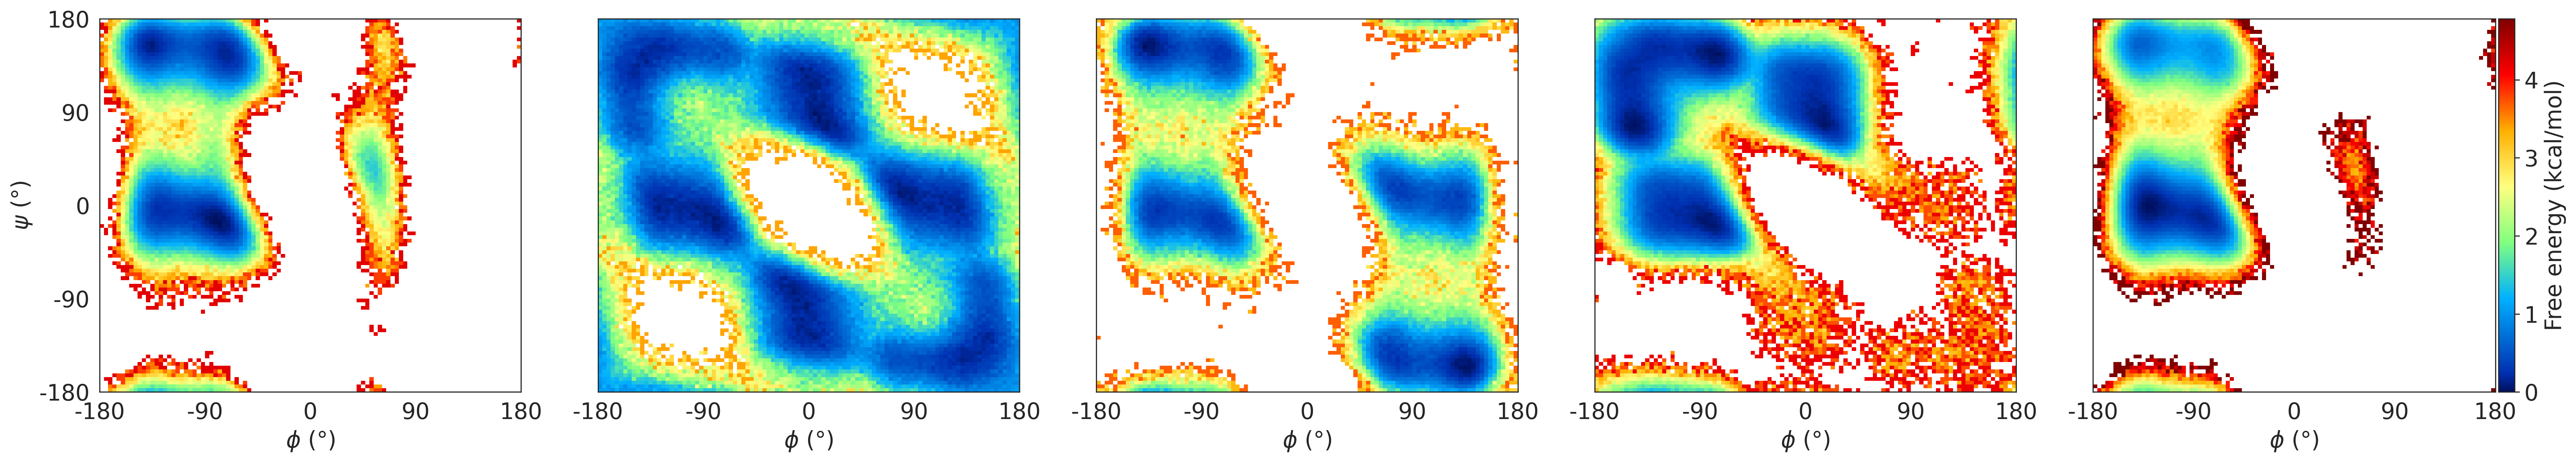

In [70]:
import importlib 
importlib.reload(utils)

fig, axes = plt.subplots(1, 5, figsize=(26, 5))
axes = axes.flatten()

bins = 100

def filter_finite(phi, psi):
	mask = np.isfinite(phi) & np.isfinite(psi)
	return phi[mask], psi[mask]


phis = [Ref_phi_heavyOnly, phis_core[0], phis_coreMap2[0], phis_coreBeta[0], phis_coreBetaMap2[0]]
psis = [Ref_psi_heavyOnly, psis_core[0], psis_coreMap2[0], psis_coreBeta[0], psis_coreBetaMap2[0]]

for i in range(len(phis)):
	phis[i], psis[i] = filter_finite(phis[i], psis[i])

scale_used = utils.determine_free_energy_scale(phis, psis, 300. * quantity.kb, bins=bins)

utils.plot_histogram_free_energy(axes[2], phis[2], psis[2], 300. * quantity.kb, scale=scale_used, bins=bins, show_yticks=False,)

utils.plot_histogram_free_energy(axes[4], phis[4], psis[4], 300. * quantity.kb, legend=True, show_yticks=False, scale=scale_used, bins=bins)

utils.plot_histogram_free_energy(axes[1], phis[1], psis[1], 300. * quantity.kb, show_ylabel=False, scale=scale_used, bins=bins, show_yticks=False,)

utils.plot_histogram_free_energy(axes[3], phis[3], psis[3], 300. * quantity.kb, scale=scale_used, bins=bins, show_yticks=False,)

utils.plot_histogram_free_energy(axes[0], Ref_phi_heavyOnly, Ref_psi_heavyOnly, 300. * quantity.kb, scale=scale_used, bins=bins, show_yticks=True,show_ylabel=True,)

plt.tight_layout()
plt.savefig('Amino_acids/thr2_low_res_comparison.pdf')
